# Imports and Load

In [176]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, kruskal, shapiro, probplot
from sklearn.model_selection import cross_validate, GridSearchCV, KFold, RandomizedSearchCV, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

import warnings

In [2]:
with open('./data/train.csv', 'r') as f:
  df = pd.read_csv(f)

In [3]:
df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


---
# 1. EDA

In [4]:
df_eda = df.copy()
df_eda.info()

<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  str    
 3   course            630000 non-null  str    
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  str    
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  str    
 9   study_method      630000 non-null  str    
 10  facility_rating   630000 non-null  str    
 11  exam_difficulty   630000 non-null  str    
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), str(7)
memory usage: 62.5 MB


In [5]:
numeric_cols = []
categorical_cols = []

for col in df_eda.columns:
    if df_eda[col].dtype in ['object', 'str']:
        categorical_cols.append(col)
    elif df_eda[col].dtype in ['int64', 'float64']:
        if df_eda[col].nunique() < 6:
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)

print(f"Numeric Columns: {numeric_cols}")
print(f"Categorical Columns: {categorical_cols}")

Numeric Columns: ['id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']
Categorical Columns: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


In [6]:
missing_values = df_eda.isnull().sum()
columns_with_nan = missing_values[missing_values > 0]

if not columns_with_nan.empty:
    print("Columns with NaN or null values:")
    print(columns_with_nan)

In [7]:
df_eda.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


### 1.1 Variáveis numéricas

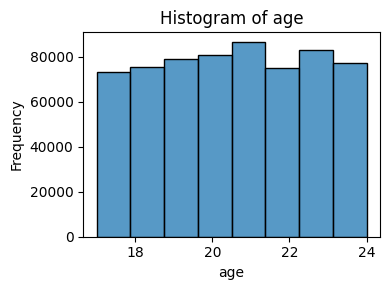

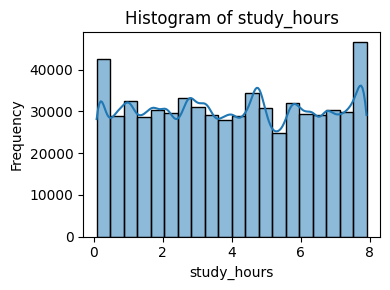

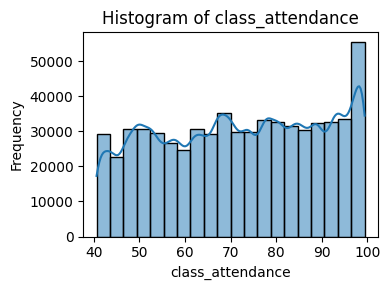

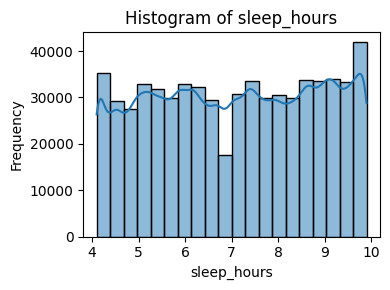

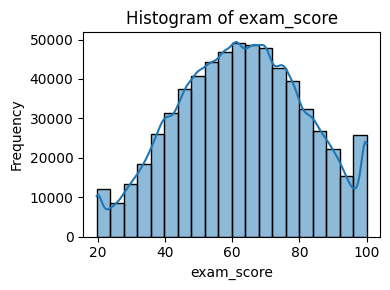

In [8]:
for column in numeric_cols:
    if column == "id":
        continue
    plt.figure(figsize=(4, 3))

    if df_eda[column].dtype == 'int64' and df_eda[column].nunique() <= 15:
        # For integer columns with few unique values, set bins to the number of unique values
        num_bins = df_eda[column].nunique()
        sns.histplot(df_eda[column], kde=False, bins=num_bins) # kde might not be meaningful for few bins
    elif df_eda[column].nunique() > 20:
        sns.histplot(df_eda[column], kde=True, bins=20)
    else:
        # For other numeric columns (floats or many unique integers), use 'auto' bins
        sns.histplot(df_eda[column], kde=True, bins='auto')

    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

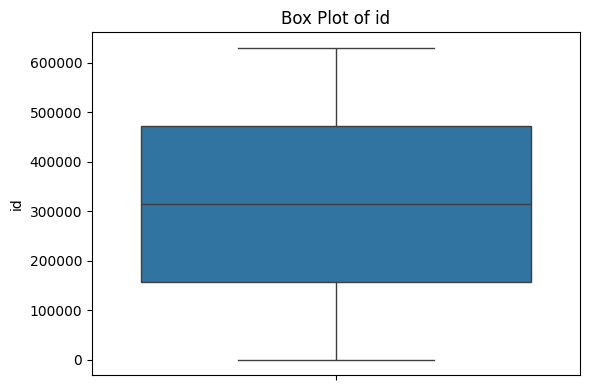

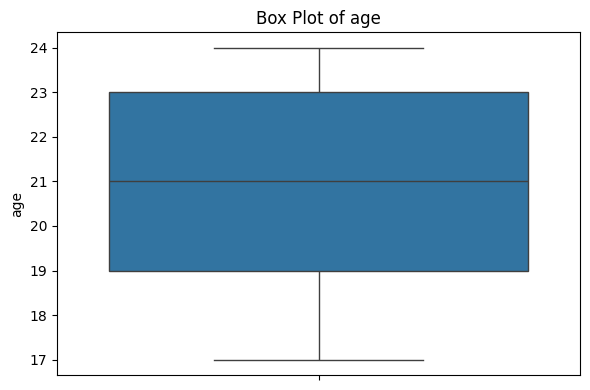

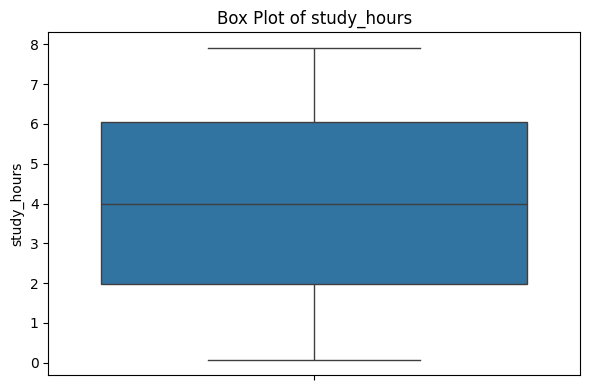

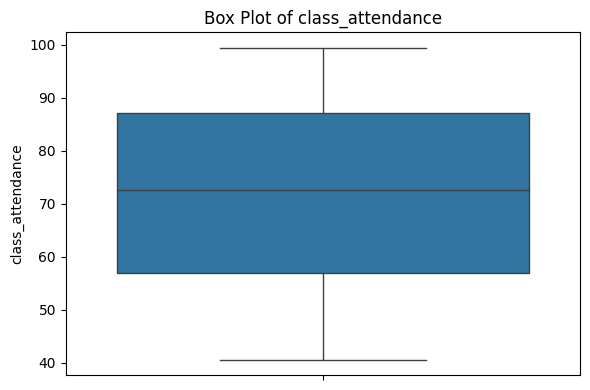

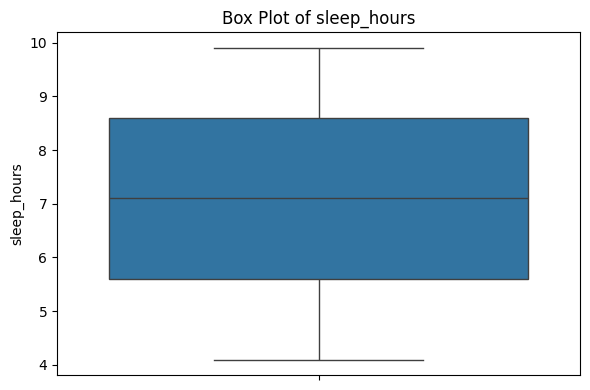

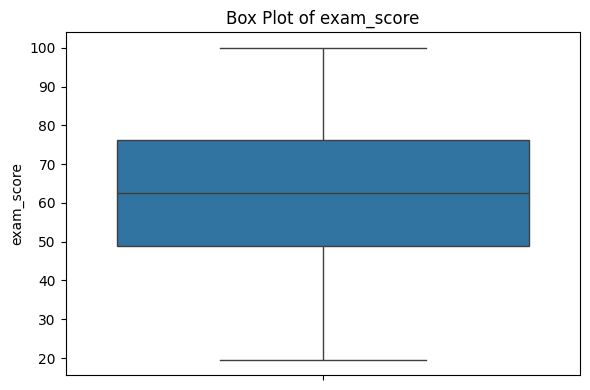

In [9]:
for column in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_eda[column])
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

In [10]:
shapiro_result = shapiro(df_eda["exam_score"])
print(f"Shapiro test p-value: {shapiro_result.pvalue}")
print(f"Shapiro test statistic: {shapiro_result.statistic}")

Shapiro test p-value: 1.9618170647675346e-84
Shapiro test statistic: 0.9895644677659794


d:\Documents\ds-ml-portfolio\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 630000.
  res = hypotest_fun_out(*samples, **kwds)


### 1.2 Variáveis categóricas

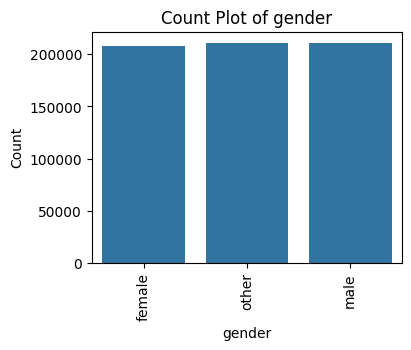

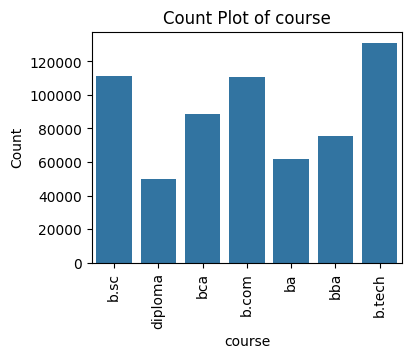

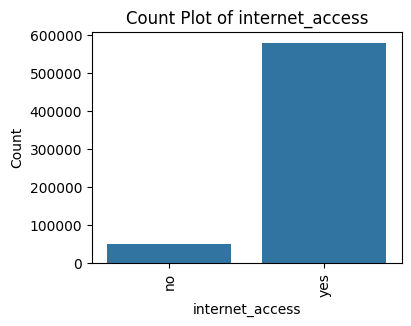

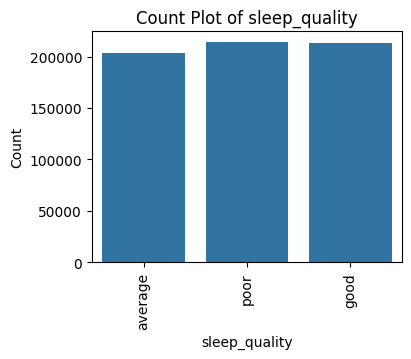

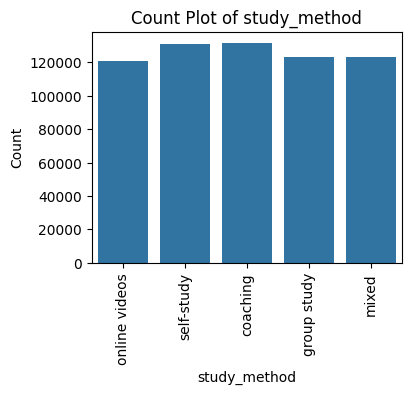

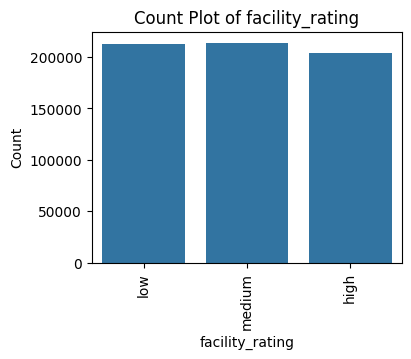

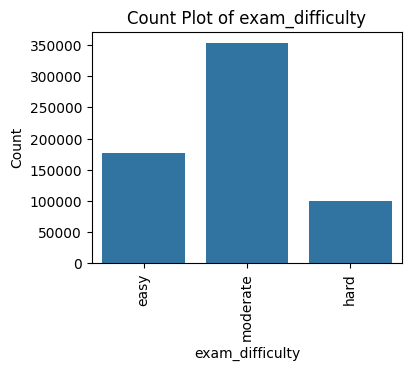

In [11]:
for column in categorical_cols:
    plt.figure(figsize=(4,3))
    sns.countplot(data=df_eda, x=column)
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

### 1.3 Relação numéricas X numéricas

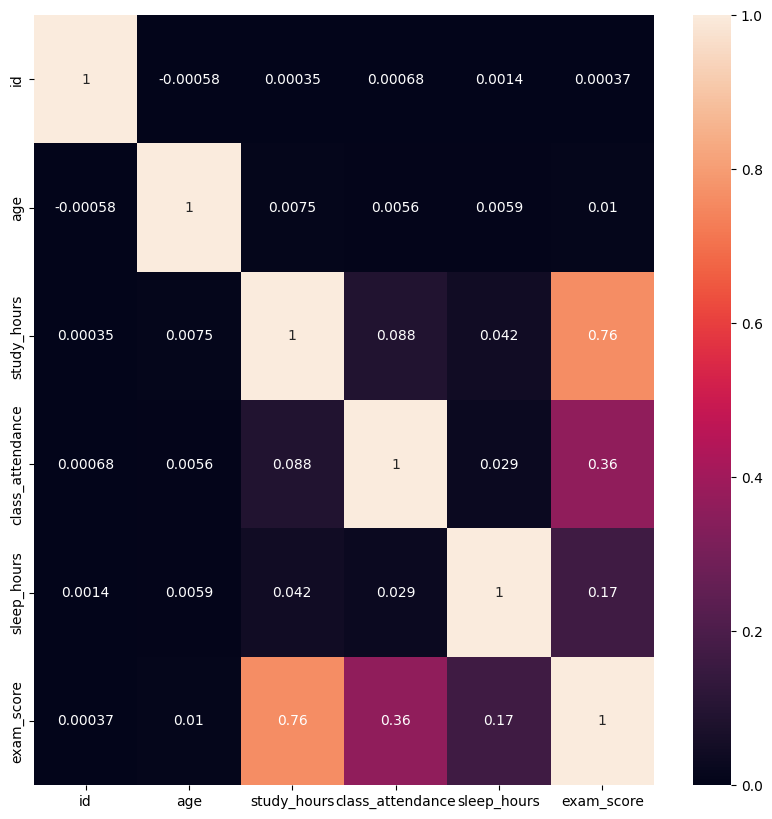

In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_eda[numeric_cols].corr(), annot=True)
plt.show()

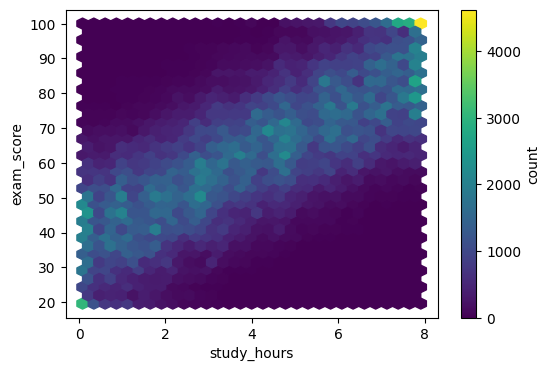

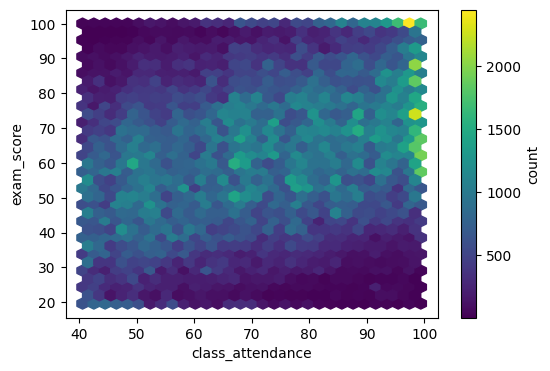

In [13]:
plt.figure(figsize=(6,4))
plt.hexbin(data=df_eda, x='study_hours', y='exam_score', gridsize=30)
plt.xlabel("study_hours")
plt.ylabel("exam_score")
plt.colorbar(label="count")
plt.show()

plt.figure(figsize=(6,4))
plt.hexbin(data=df_eda, x='class_attendance', y='exam_score', gridsize=30)
plt.xlabel("class_attendance")
plt.ylabel("exam_score")
plt.colorbar(label="count")
plt.show()

### 1.4 Relação target X numéricas

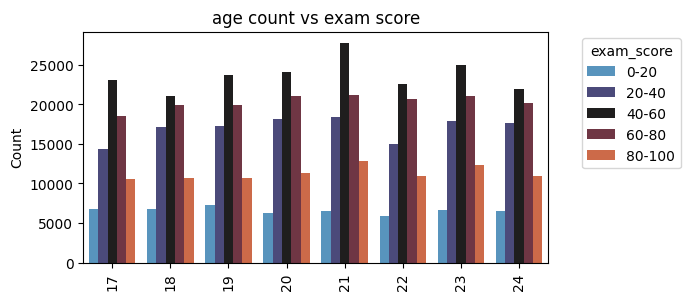

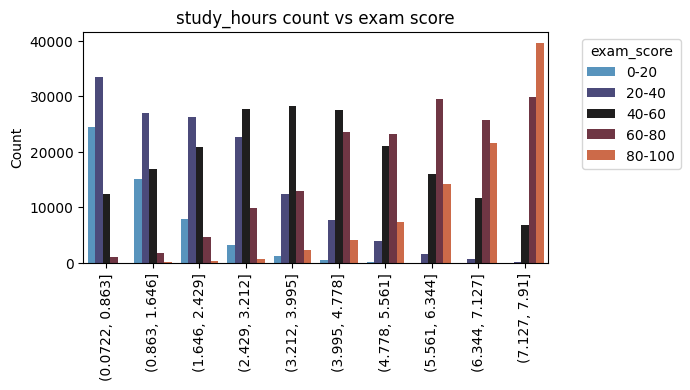

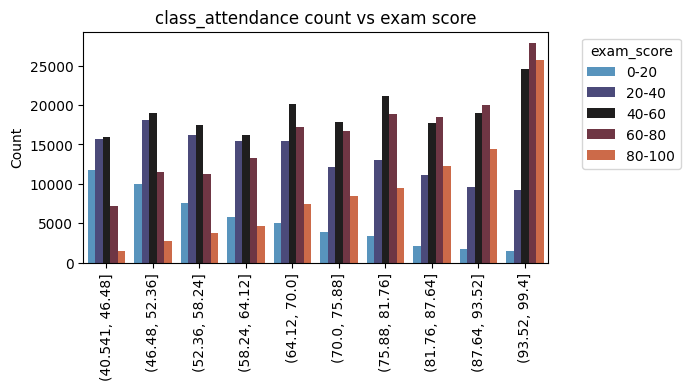

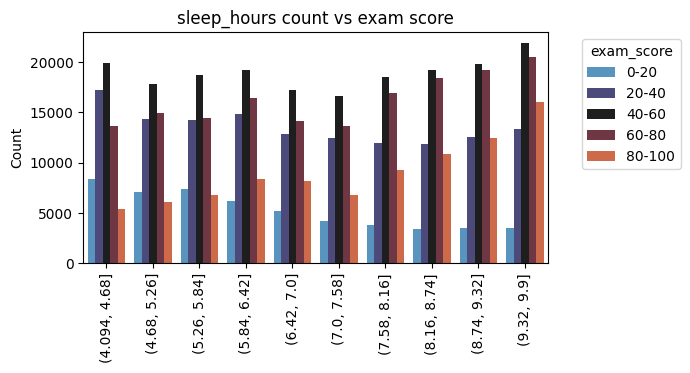

In [14]:
df_eda_countplot = df_eda.copy()

df_eda_countplot["exam_score"] = pd.cut(df_eda_countplot["exam_score"], bins=5, labels=["0-20", "20-40", "40-60", "60-80", "80-100"])


for col in numeric_cols:
    if col == "exam_score" or col == "id":
        continue
    if df_eda_countplot[col].nunique() > 10:
        df_eda_countplot[col] = pd.cut(df_eda_countplot[col], bins=10)
    plt.figure(figsize=(6, 3))
    ax = sns.countplot(data=df_eda_countplot, x=col, hue='exam_score', palette="icefire")
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
    plt.title(f'{col} count vs exam score')
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

### 1.5 Relação target X categóricas

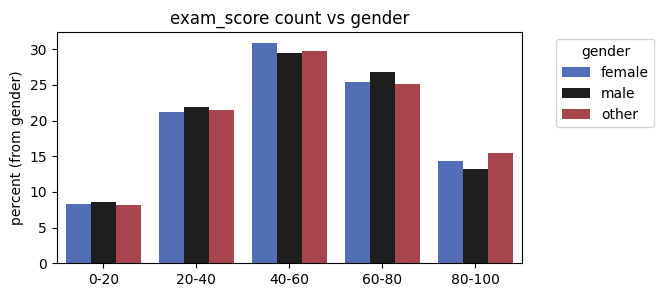

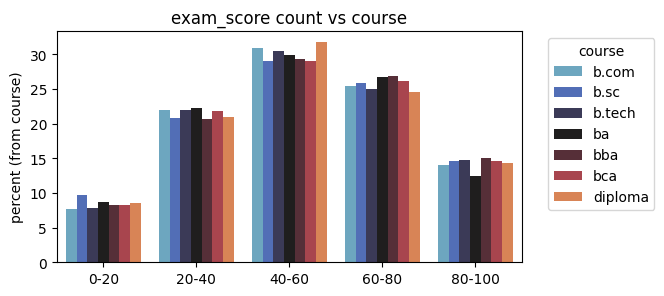

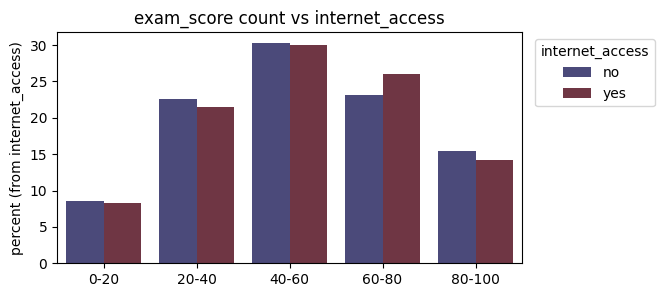

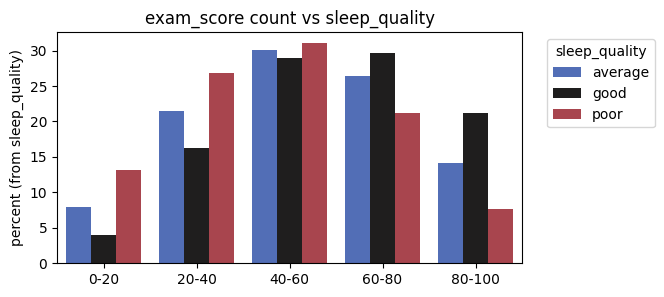

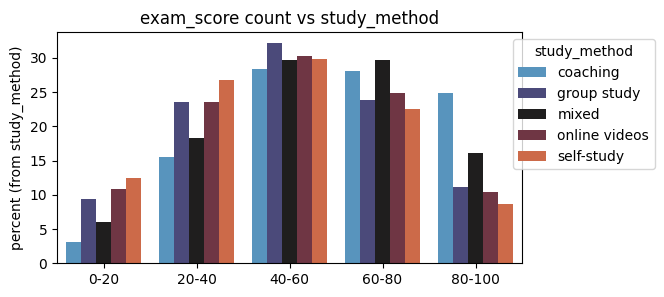

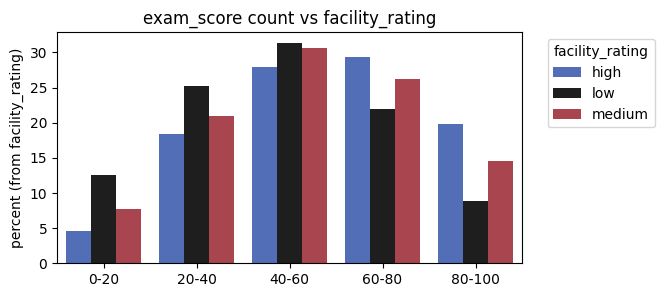

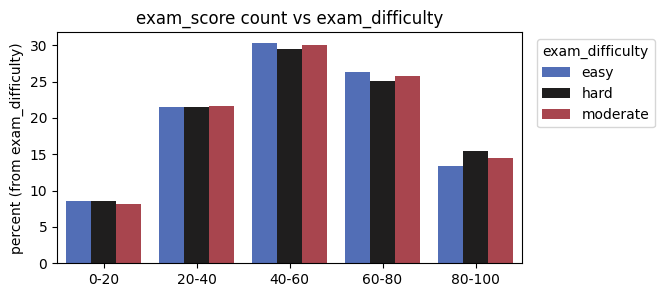

In [15]:
df_eda_countplot_perc = df_eda_countplot.copy()
for col in categorical_cols:
    df_pct = (
        df_eda_countplot_perc
        .groupby(["exam_score", col], as_index=False, observed=True)
        .size()
    )

    df_pct["percent"] = (
        df_pct.groupby(col, observed=True)["size"]
        .transform(lambda x: x * 100 / x.sum())
    )

    plt.figure(figsize=(6, 3))
    ax = sns.barplot(
        data=df_pct,
        x="exam_score",
        y="percent",
        hue=col,
        palette="icefire"
    )
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
    plt.title(f'exam_score count vs {col}')
    plt.xlabel('')
    plt.ylabel(f'percent (from {col})')
    plt.show()

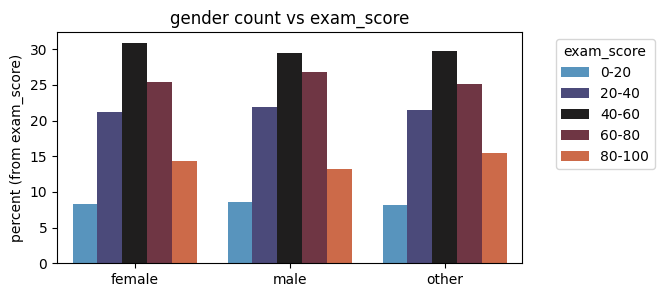

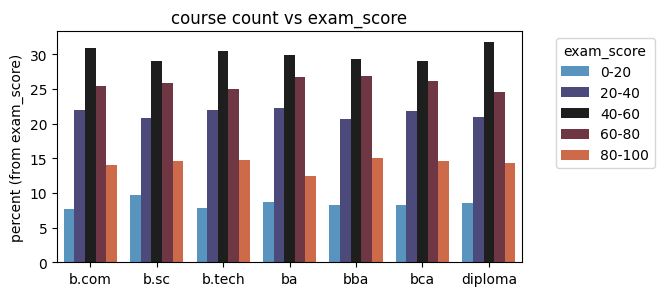

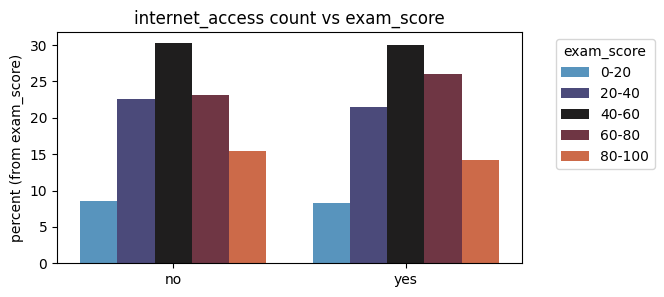

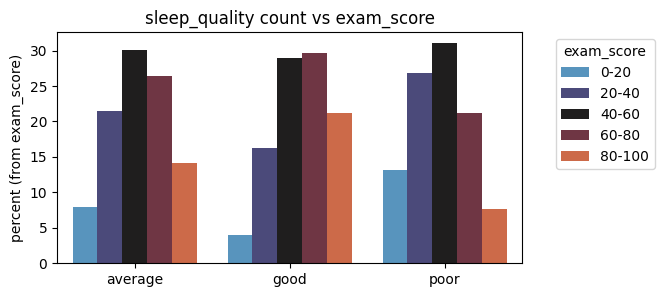

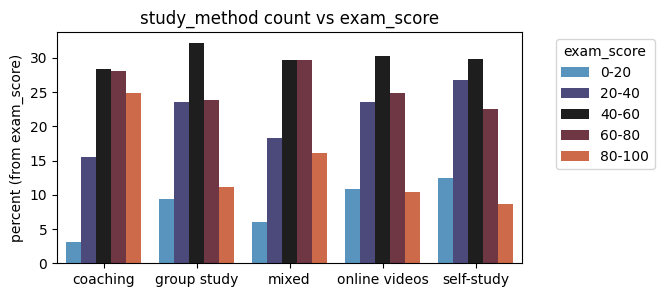

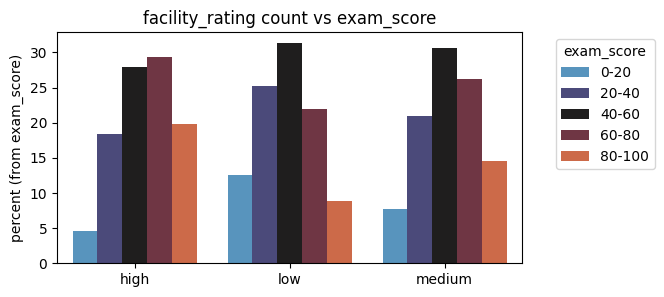

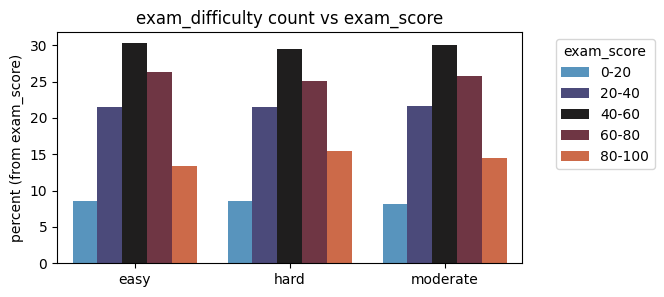

In [16]:
df_eda_countplot_perc = df_eda_countplot.copy()
for col in categorical_cols:
    df_pct = (
        df_eda_countplot_perc
        .groupby([col, "exam_score"], as_index=False, observed=True)
        .size()
    )

    df_pct["percent"] = (
        df_pct.groupby(col, observed=True)["size"]
        .transform(lambda x: x * 100 / x.sum())
    )

    plt.figure(figsize=(6, 3))
    ax = sns.barplot(
        data=df_pct,
        x=col,
        y="percent",
        hue="exam_score",
        palette="icefire"
    )
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
    plt.title(f'{col} count vs exam_score')
    plt.xlabel('')
    plt.ylabel(f'percent (from exam_score)')
    plt.show()

### 1.6 Relação numéricas X categóricas ordinais

In [17]:
df_eda_ordinal = df_eda.copy()

categorical_ordinal_cols = ["sleep_quality", "facility_rating", "exam_difficulty"]
for col in categorical_ordinal_cols:
    print(f"{col}: {df_eda_ordinal[col].unique()}")
df_eda_ordinal["sleep_quality"] = df_eda_ordinal["sleep_quality"].map({"poor": 0, "average": 1, "good": 2})
df_eda_ordinal["facility_rating"] = df_eda_ordinal["facility_rating"].map({"low": 0, "medium": 1, "high": 2})
df_eda_ordinal["exam_difficulty"] = df_eda_ordinal["exam_difficulty"].map({"easy": 0, "moderate": 1, "hard": 2})

sleep_quality: <StringArray>
['average', 'poor', 'good']
Length: 3, dtype: str
facility_rating: <StringArray>
['low', 'medium', 'high']
Length: 3, dtype: str
exam_difficulty: <StringArray>
['easy', 'moderate', 'hard']
Length: 3, dtype: str


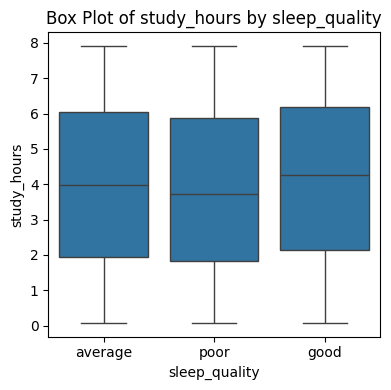

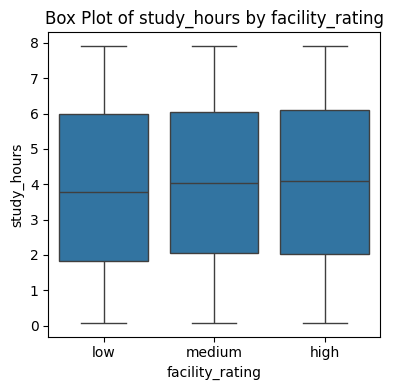

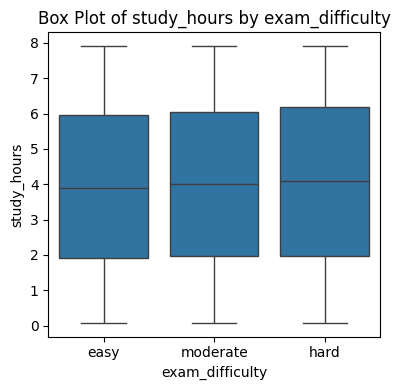

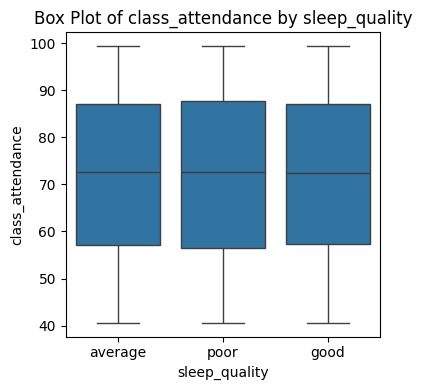

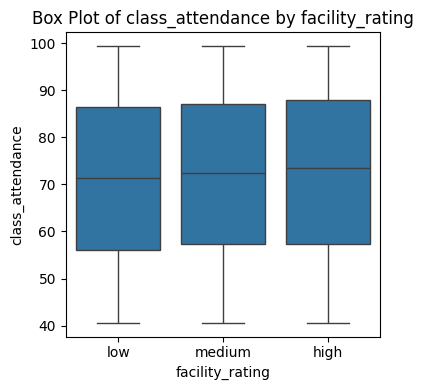

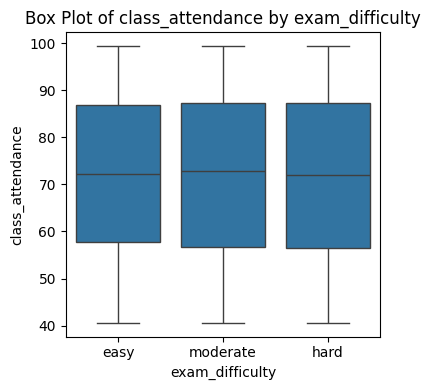

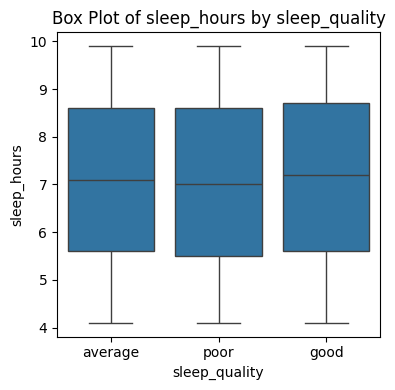

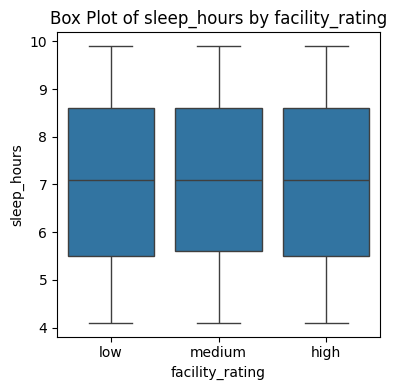

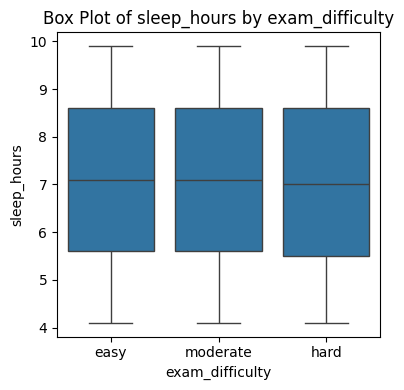

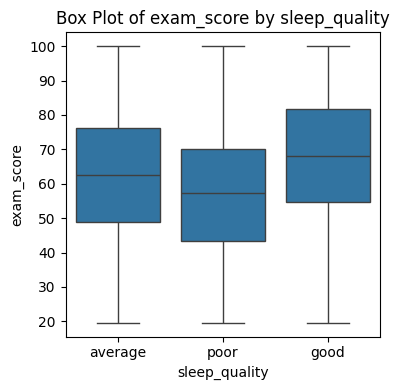

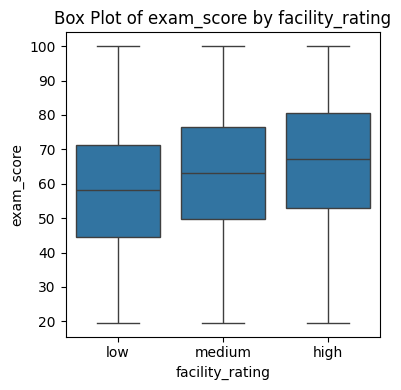

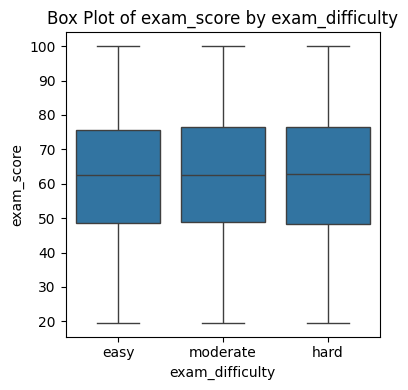

In [18]:
for num_col in numeric_cols:
    if num_col in ["id", "age"]:
        continue
    for cat_col in categorical_ordinal_cols:

        plt.figure(figsize=(4, 4))
        sns.boxplot(y=df_eda[num_col], x=df_eda[cat_col])
        plt.title(f'Box Plot of {num_col} by {cat_col}')
        plt.ylabel(num_col)
        plt.xlabel(cat_col)
        plt.tight_layout()
        plt.show()

In [19]:
for num_col in numeric_cols:
    if num_col in ["id", "age"]:
        continue
    for cat_col in categorical_ordinal_cols:
        corr = spearmanr(a=df_eda_ordinal[num_col], b=df_eda_ordinal[cat_col])
        if corr.pvalue < 0.05:
            print(f"{num_col} X {cat_col} spearman correlation: {corr.statistic}")
            print(f"{num_col} X {cat_col} spearman pvalue: {corr.pvalue}")
            print("")

study_hours X sleep_quality spearman correlation: 0.05157134852125861
study_hours X sleep_quality spearman pvalue: 0.0

study_hours X facility_rating spearman correlation: 0.030606506777979835
study_hours X facility_rating spearman pvalue: 2.018152134888223e-130

study_hours X exam_difficulty spearman correlation: 0.012840894287273856
study_hours X exam_difficulty spearman pvalue: 2.140876214434387e-24

class_attendance X facility_rating spearman correlation: 0.030106508537580512
class_attendance X facility_rating spearman pvalue: 2.942658180198399e-126

sleep_hours X sleep_quality spearman correlation: 0.02547046451872973
sleep_hours X sleep_quality spearman pvalue: 6.555583799022011e-91

sleep_hours X exam_difficulty spearman correlation: -0.0068239940974903065
sleep_hours X exam_difficulty spearman pvalue: 6.080087704947658e-08

exam_score X sleep_quality spearman correlation: 0.2294048009436642
exam_score X sleep_quality spearman pvalue: 0.0

exam_score X facility_rating spearman c

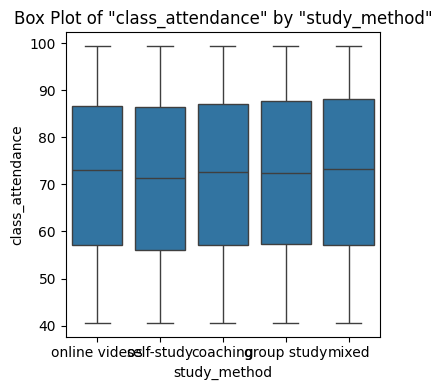

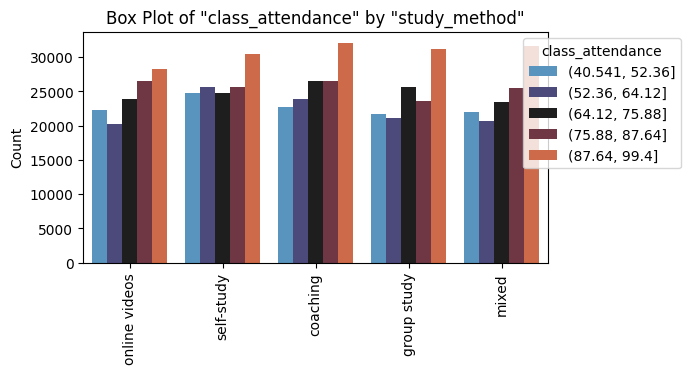

In [20]:
plt.figure(figsize=(4, 4))
sns.boxplot(y=df_eda["class_attendance"], x=df_eda["study_method"])
plt.title(f'Box Plot of "class_attendance" by "study_method"')
plt.ylabel("class_attendance")
plt.xlabel("study_method")
plt.tight_layout()
plt.show()

df_eda_temp = df_eda.copy()
df_eda_temp["class_attendance"] = pd.cut(df_eda_temp["class_attendance"], bins=5)
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df_eda_temp, hue="class_attendance", x='study_method', palette="icefire")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
plt.title(f'Box Plot of "class_attendance" by "study_method"')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

### 1.7 Relação target X categóricas nominais

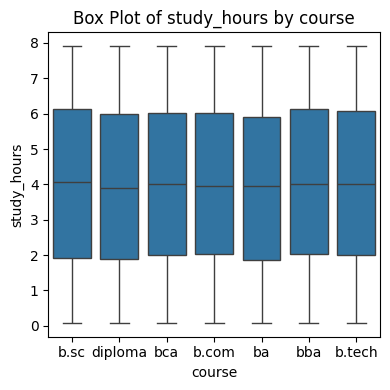

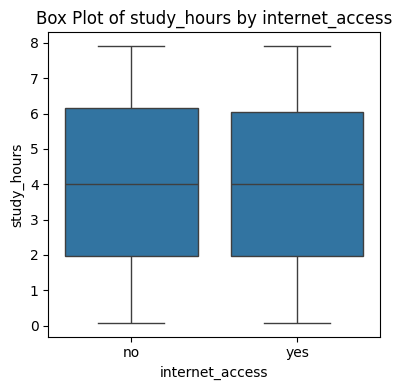

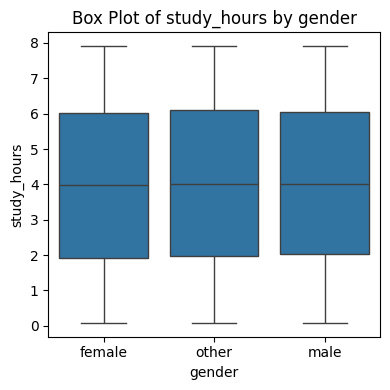

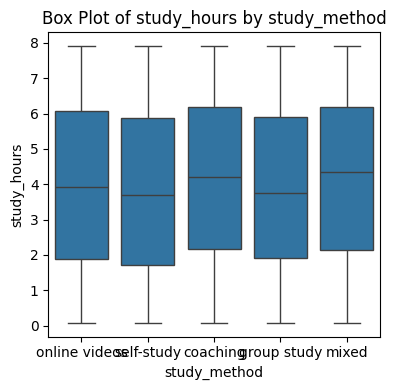

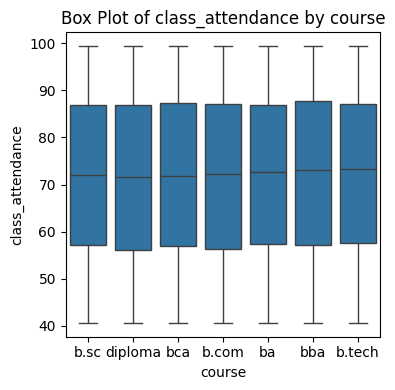

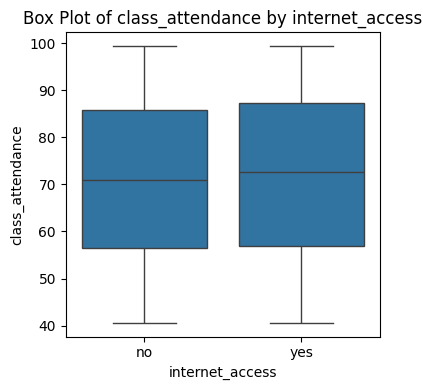

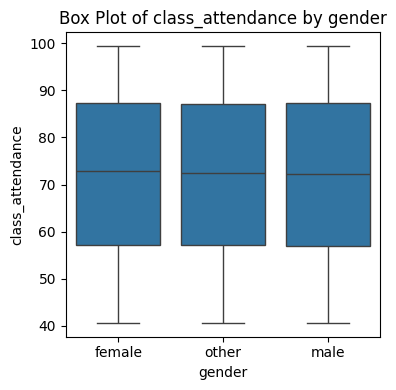

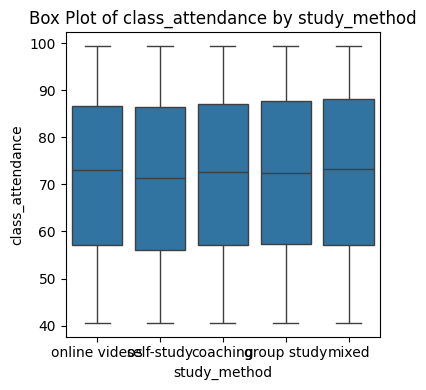

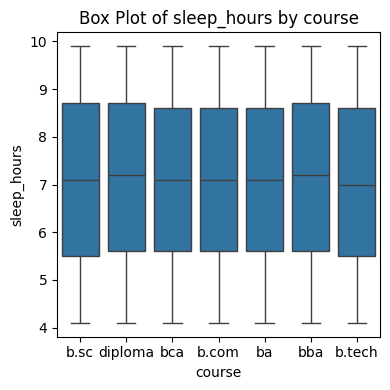

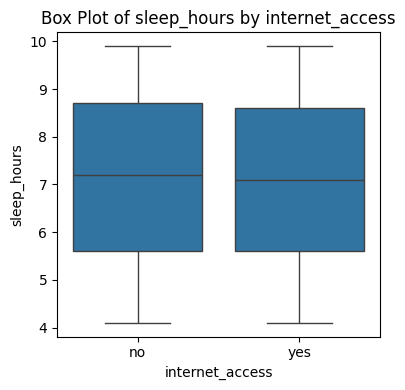

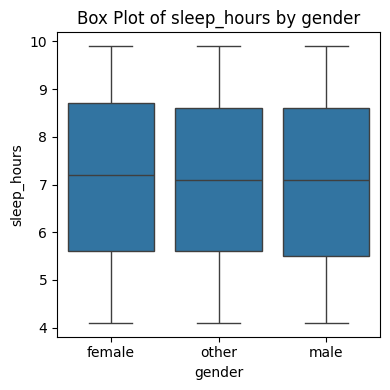

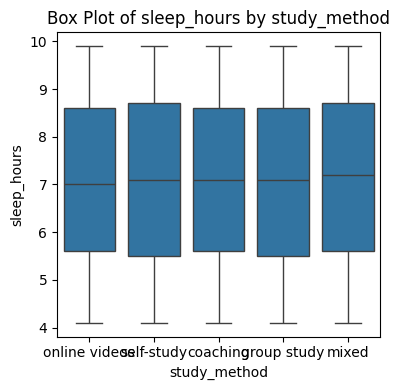

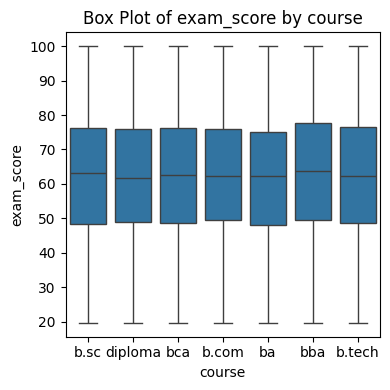

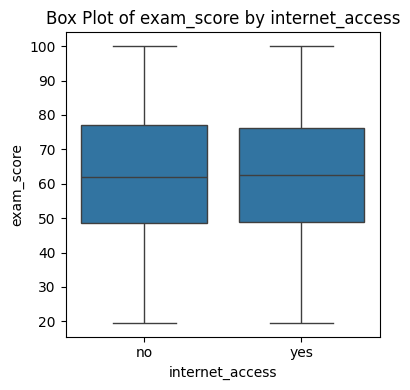

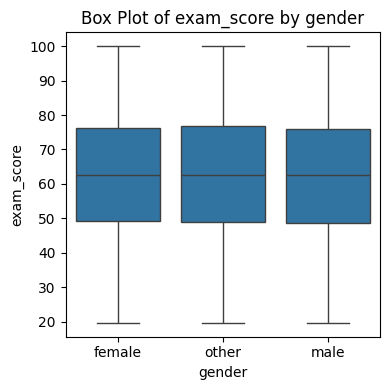

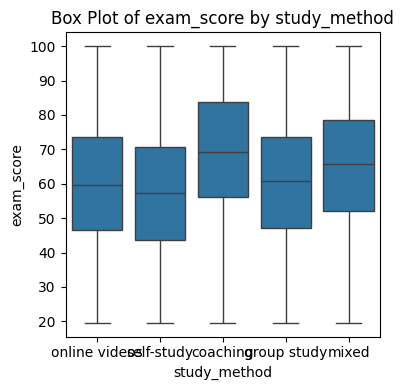

In [21]:
categorical_nominal_cols = ["course", "internet_access", "gender", "study_method"]

for num_col in numeric_cols:
    if num_col in ["id", "age"]:
        continue
    for cat_col in categorical_nominal_cols:

        plt.figure(figsize=(4, 4))
        sns.boxplot(y=df_eda[num_col], x=df_eda[cat_col])
        plt.title(f'Box Plot of {num_col} by {cat_col}')
        plt.ylabel(num_col)
        plt.xlabel(cat_col)
        plt.tight_layout()
        plt.show()

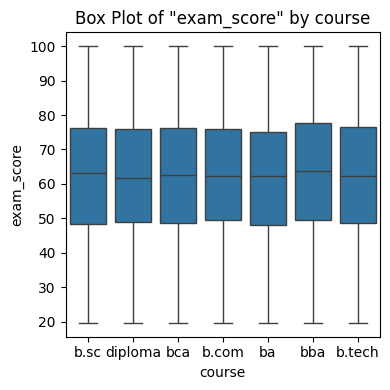

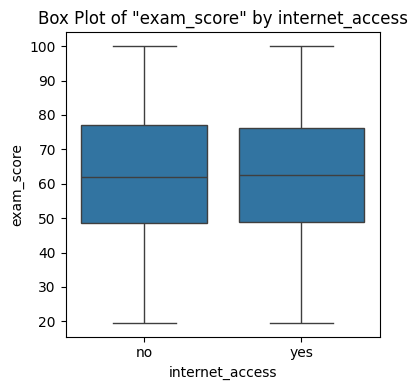

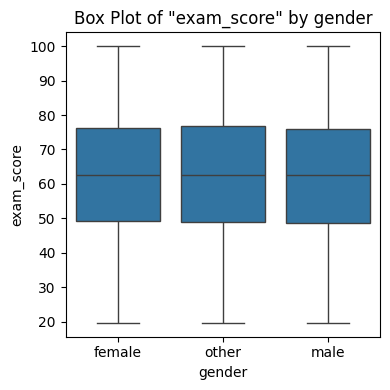

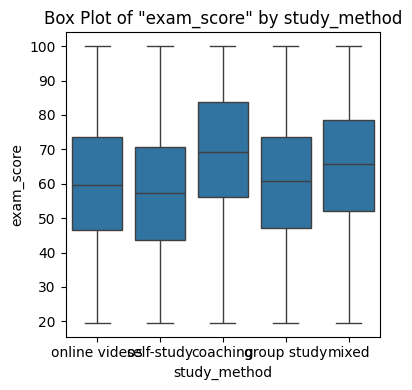

In [22]:
categorical_nominal_cols = ["course", "internet_access", "gender", "study_method"]

for col in categorical_nominal_cols:
    plt.figure(figsize=(4, 4))
    sns.boxplot(y=df_eda["exam_score"], x=df_eda[col])
    plt.title(f'Box Plot of "exam_score" by {col}')
    plt.ylabel(num_col)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [23]:
def calculate_epsilon_squared(H, k, N):
    """Calculate epsilon squared for Kruskal-Wallis H-test."""
    return (H - k + 1) / (N - 1)

categorical_cols_for_kruskal = ["study_method", "course"]

for cat_col in categorical_cols_for_kruskal:
    print(f"{cat_col} X exam_score")

    unique_categories = df_eda[cat_col].unique()

    data_groups = []
    for category in unique_categories:
        group_scores = df_eda[df_eda[cat_col] == category]['exam_score'].values
        data_groups.append(group_scores)

    H_statistic, p_value = kruskal(*data_groups)

    k = len(unique_categories)
    N = len(df_eda['exam_score'])

    epsilon_sq = calculate_epsilon_squared(H_statistic, k, N)

    print(f"Kruskal-Wallis H-statistic: {H_statistic:.4f}")
    print(f"Kruskal-Wallis p-value: {p_value:.4f}")
    print(f"Epsilon Squared: {epsilon_sq:.4f}")

study_method X exam_score
Kruskal-Wallis H-statistic: 29548.4198
Kruskal-Wallis p-value: 0.0000
Epsilon Squared: 0.0469
course X exam_score
Kruskal-Wallis H-statistic: 199.2840
Kruskal-Wallis p-value: 0.0000
Epsilon Squared: 0.0003


---
## 1.8 Análises e conclusões

### 1.8a Análise univariável de colunas numéricas

#### Tipos de distribuição
Obeservando os histogramas das colunas numéricas `age`, `study_hours`, `class_attendance`, `sleep_hours` com binning, a distribuição se assemelha à uma distribuição uniforme dos valores. Os box plots dessas variáveis também reforçam essa semelhança pois tanto os intervalos interquartis.

Já para a coluna numérica `exam_score`, a distribuição "binnarizada" se aproxima bastante de uma distribuição gaussiana, salvo uma quantidade considerável de valores extremos, quando próximos de 20 e 100, fortemente indicando um clipping. Porém, fazerndo um teste Shapiro-Wilk para normalidade, o resultado é descartar a hipótese nula pois `pvalue < 0.05`

#### Outliers
Nenhuma variável numérica apresentou outliers

Dado o tipo de distribuição, a ausência de outliers e ausência de valores faltantes, tudo indica que esse dataset já sofreu um preprocessamento.

---
### 1.8b Análise univariável de colunas categáricas

#### Tipos de distribuição

A contagem de valores das variáveis categóricas mostram que as categorias das variáveis `gender`, `sleep_quantity`, `study_method` e `facility_rating` estão uniformemente distribuídas.

As variáveis categoricas restantes `course`, `internet_access` e `exam_dificulty` não seguem uma distribuição uniforme. Principalemente `internet_access` e `exam_dificulty`, que mostram que praticamente a maioria dos dados tem acesso à internet; e que mais da metade dos dados são de exames de dificuldade média.

---
### 1.8c Análise bivariável

#### Variáveis numéricas X Target

O heatmap de correlação entre variáveis numéricas mostram duas correlações consideráveis: `study_hours` x `exam_score` (0.76) e `class_attendance` x `exam_score` (0.36). Essas correlações se mostram ainda mais relevantes pois se tratam de correlações à variável target. Os gráficos de histograma de `exam_score` agrupados por `study_hours` e `class_attendance`; e gráficos de grouped barchart percetuais `study_hours` x `exam_score` e `class_attendance` x `exam_score` reforçam essa correlação.

#### Variáveis categóricas X Target

Os gráficos de grouped barchart também mostram que há uma pequena influência das variáveis categóricas `sleep_quality`, `study_method`, `facility_rating` sobre a variável `exam_score`. A correlação de Pearson mostra que em todos há uma correlação (p-value < 0.05), mas apenas o `exam_score` X `sleep_quality` tem um coeficiente minimamente considerável (0.2294), mas ainda pequeno.

O box-plot de `exam_score` por `study_method` mostra uma clara diferença das distribuições entre as classes de `study_method`. Ao realizar o teste de Kruskal-Wallis, a hipótese nula foi descartada, indicando que as medianas dos diferentes grupos não são iguais. Além disso, o resultado apresenta um H-statistic alto (29548.4198), ou seja, indica que há diferença entre as classes e essa diferença é estatisticamente bem significativa. Apesar desse resultado, o effect size epsilon squared indica que a diferença de `exam_score` entre as classes são baixas (0.0469).

#### Outras relações
Apesar das duas variáveis `sleep_quality` e `sleep_quantity` se tratarem do mesmo tema, a correlação de Pearson indica que elas tem sim correlação, mas ela é desprezível (0.0254).



---
# 2. Data Wrangling

O EDA mostrou que não é necessário fazer um data wrangling pois os dados estão com tipos corretos, sem valores faltantes, erros, duplicados ou inconsistências. Também não há outliers para tratar.


As únicas alterações são padronizar os nomes de colunas para snake case e dropar a coluna id.

In [24]:
df_wrangled = df.copy()
df_wrangled.columns = [col.lower().replace(" ", "_") for col in df_wrangled.columns]
df_wrangled.drop(["id"], axis=1, inplace=True)

---
# 3. Dataset split

In [70]:
df_copy = df_wrangled.copy()
X_train = df_copy.drop('exam_score', axis=1)
y_train = df_copy['exam_score']

# # Split into training and temporary (validation + test) sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Split the temporary set into validation and test sets (50% validation, 50% test of the temp set, resulting in 15% each of original)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
# print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
# print(f"Test set shape: {X_test.shape}, {y_test.shape}")


cv = KFold(n_splits=3, shuffle=True, random_state=42)

numeric_cols_ = []
categorical_cols_ = []

for col in X_train.columns:
    if X_train[col].dtype in ['object', 'str']:
        categorical_cols_.append(col)
    elif X_train[col].dtype in ['int64', 'float64']:
        if X_train[col].nunique() < 6:
            categorical_cols_.append(col)
        else:
            numeric_cols_.append(col)

print(f"Numeric Columns: {numeric_cols_}")
print(f"Categorical Columns: {categorical_cols_}")

scoring = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}

Training set shape: (630000, 11), (630000,)
Numeric Columns: ['age', 'study_hours', 'class_attendance', 'sleep_hours']
Categorical Columns: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


---
# 4. Feature Engineering

In [26]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_configs=None, ratio_configs=None):
        """
        group_configs: list of tuples (value_col, group_col)
        ratio_configs: list of tuples (numerator, denominator)
        """
        self.group_configs = group_configs or []
        self.ratio_configs = ratio_configs or []

    def fit(self, X, y=None):
        self.group_stats_ = {}

        for value_col, group_col in self.group_configs:
            means = X.groupby(group_col)[value_col].mean()
            stds = X.groupby(group_col)[value_col].std()

            self.group_stats_[(value_col, group_col)] = {
                "means": means,
                "stds": stds,
                "global_mean": X[value_col].mean(),
                "global_std": X[value_col].std()
            }

        return self

    def transform(self, X):
        check_is_fitted(self, "group_stats_")

        X_ = X.copy()

        # Group features
        for (value_col, group_col), stats in self.group_stats_.items():

            X_[f"{value_col}_mean_by_{group_col}"] = (
                X_[group_col]
                .map(stats["means"])
                .fillna(stats["global_mean"])
            )

            X_[f"{value_col}_std_by_{group_col}"] = (
                X_[group_col]
                .map(stats["stds"])
                .fillna(stats["global_std"])
            )

        # Ratio features
        for numerator, denominator in self.ratio_configs:
            X_[f"{numerator}_{denominator}_ratio"] = (
                X_[numerator] / X_[denominator]
            )

        return X_
    
feature_engineering = FeatureEngineeringTransformer(
    group_configs=[
        ('study_hours', 'sleep_quality'),
        ('class_attendance', 'facility_rating'),
        ('sleep_hours', 'sleep_quality'),
        ('study_hours', 'study_method')
    ],
    ratio_configs=[
        ('study_hours', 'sleep_hours'),
        ('class_attendance', 'study_hours')
    ]
)

In [27]:
X_train_engineering_ = X_train.copy()

X_train_engineering_ = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough').set_output(transform="pandas").fit_transform(X_train_engineering_)

X_train_engineering = X_train.copy()

X_train_engineering = FeatureEngineeringTransformer(
    group_configs=[
        ('study_hours', 'sleep_quality'),
        ('class_attendance', 'facility_rating'),
        ('sleep_hours', 'sleep_quality'),
        ('study_hours', 'study_method')
    ],
    ratio_configs=[
        ('study_hours', 'sleep_hours'),
        ('class_attendance', 'study_hours')
    ]
).fit(X_train_engineering).transform(X_train_engineering)

X_train_engineering = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough').set_output(transform="pandas").fit_transform(X_train_engineering)

# Rank comparison
rank_ = np.linalg.matrix_rank(X_train_engineering_)
n_cols_ = X_train_engineering_.shape[1]
print(f"No Feature Eng - N cols: {n_cols_}; Rank: {rank_}")

rank = np.linalg.matrix_rank(X_train_engineering)
n_cols = X_train_engineering.shape[1]
print(f"Feature Eng - N cols: {n_cols}; Rank: {rank}")
print("")

# Cond comparison
print("No Feature Eng - Condition Number: ", np.linalg.cond(X_train_engineering_))
print("Feature Eng - Condition Number: ", np.linalg.cond(X_train_engineering))
print("")

# VIF
vif_data_ = pd.DataFrame()
vif_data_["feature"] = X_train_engineering_.columns
vif_data_["VIF"] = [
    variance_inflation_factor(X_train_engineering_.values, i) for i in range(X_train_engineering_.shape[1])
]
print("No Feature Eng - VIF")
print(vif_data_.loc[vif_data_['VIF'] > 5])

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_engineering.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train_engineering.values, i) for i in range(X_train_engineering.shape[1])
]
print("Feature Eng - VIF")
print(vif_data.loc[vif_data['VIF'] > 5])


No Feature Eng - N cols: 23; Rank: 23
Feature Eng - N cols: 33; Rank: 26

No Feature Eng - Condition Number:  9.293915114468629
Feature Eng - Condition Number:  1.0989075247774924e+16

No Feature Eng - VIF
                     feature       VIF
12  cat__internet_access_yes  7.621801
Feature Eng - VIF
                                          feature           VIF
1                                num__study_hours  1.340097e+01
4          num__study_hours_mean_by_sleep_quality  1.032592e+06
5           num__study_hours_std_by_sleep_quality  1.672679e+09
6   num__class_attendance_mean_by_facility_rating  2.431410e+06
7    num__class_attendance_std_by_facility_rating  1.817265e+07
8          num__sleep_hours_mean_by_sleep_quality  9.503175e+06
9           num__sleep_hours_std_by_sleep_quality  2.048543e+07
10          num__study_hours_mean_by_study_method  2.502481e+06
11           num__study_hours_std_by_study_method  2.324459e+06
12             num__study_hours_sleep_hours_ratio  1.52207

Considerando as features criadas durante o feature engineering, o matrix rank, o condition number e o VIF indicam que há multicolinearidade.
- O matrix rank calcula a quantidade de variáveis linearmente independentes. Apenas 26 das 33 colunas com novas features são linearmente independentes.
- O condition number indica a sensibilidade do sistema linear dado uma alteração do input (variáveis). Um condition number = 1 indica que o sistema é perfeitamente linear. O resultado obtido mostra um condition number absurdamente alto, resultado de uma multicolinearidade alta.
- O VIF (variance inflation factor) comprova a multicolinearidade, pois aponta multiplas variáveis com VIF > 5, incluíndo várias com VIF > 10. Isso significa que a adição dessas features novas aumentam a variância das variáveis origiais, resultado da multiclinearidade.

Portanto, o feature engineering não será utilizado para os modelos lineares sem regressão.

---
# 5. Modeling

In [28]:
def create_scores_df(cv_results, grid=None):
    global y_std

    if grid:
        mean_values = [
            grid.cv_results_['mean_train_rmse'][grid.best_index_],
            grid.cv_results_['mean_test_rmse'][grid.best_index_],
            grid.cv_results_['mean_train_mae'][grid.best_index_],
            grid.cv_results_['mean_test_mae'][grid.best_index_],
            grid.cv_results_['mean_train_r2'][grid.best_index_],
            grid.cv_results_['mean_test_r2'][grid.best_index_],
            grid.cv_results_['mean_train_rmse'][grid.best_index_]/y_std,
            grid.cv_results_['mean_test_rmse'][grid.best_index_]/y_std,
            grid.cv_results_['mean_train_mae'][grid.best_index_]/y_std,
            grid.cv_results_['mean_test_mae'][grid.best_index_]/y_std
        ]

        std_values = [
            grid.cv_results_['std_train_rmse'][grid.best_index_],
            grid.cv_results_['std_test_rmse'][grid.best_index_],
            grid.cv_results_['std_train_mae'][grid.best_index_],
            grid.cv_results_['std_test_mae'][grid.best_index_],
            grid.cv_results_['std_train_r2'][grid.best_index_],
            grid.cv_results_['std_test_r2'][grid.best_index_],
            np.nan,
            np.nan,
            np.nan,
            np.nan
        ]
    else:
        mean_values = [
            np.mean(cv_results["train_rmse"]),
            np.mean(cv_results["test_rmse"]),
            np.mean(cv_results["train_mae"]),
            np.mean(cv_results["test_mae"]),
            np.mean(cv_results["train_r2"]),
            np.mean(cv_results["test_r2"]),
            np.mean(cv_results["train_rmse"])/y_std,
            np.mean(cv_results["test_rmse"])/y_std,
            np.mean(cv_results["train_mae"])/y_std,
            np.mean(cv_results["test_mae"])/y_std,
        ]

        std_values = [
            np.std(cv_results["train_rmse"], ddof=1),
            np.std(cv_results["test_rmse"], ddof=1),
            np.std(cv_results["train_mae"], ddof=1),
            np.std(cv_results["test_mae"], ddof=1),
            np.std(cv_results["train_r2"], ddof=1),
            np.std(cv_results["test_r2"], ddof=1),
            np.nan,
            np.nan,
            np.nan,
            np.nan,
        ]

    scores_df = pd.DataFrame({
        "score": ["train_rmse", "val_rmse", "train_mae", "val_mae", "train_r2", "val_r2", "train_rmse/std", "val_rmse/std", "train_mae/std", "val_mae/std"],
        "mean": mean_values,
        "std": std_values,
    }).set_index("score")

    return scores_df

---
## 5.1 Triage

A triagem inicial tem como objetivos:
- Definir modelos baselines.
- Realizar treino simples e validar diferentes modelos.
- Comprar e selecionar modelos para fazer treino e validação na próxima etapa.

#### Baseline model


In [29]:
class MeanRegressor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.mean_ = np.mean(y)
        return self

    def predict(self, X):
        return np.full(shape=(len(X),), fill_value=self.mean_)

mean_reg_pipeline = Pipeline([
        ('model', MeanRegressor())
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

mean_reg_cv = cross_validate(mean_reg_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(mean_reg_cv))

class MedianRegressor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.median_ = np.median(y)
        return self

    def predict(self, X):
        return np.full(shape=(len(X),), fill_value=self.median_)

median_reg_pipeline = Pipeline([
        ('model', MedianRegressor())
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

median_reg_cv = cross_validate(median_reg_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(median_reg_cv))

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


                     mean       std
score                              
train_rmse     -18.916848  0.020254
val_rmse       -18.916911  0.040455
train_mae      -15.545266  0.021270
val_mae        -15.545356  0.042352
train_r2         0.000000  0.000000
val_r2          -0.000013  0.000012
train_rmse/std  -0.999998       NaN
val_rmse/std    -1.000001       NaN
train_mae/std   -0.821767       NaN
val_mae/std     -0.821771       NaN
                     mean       std
score                              
train_rmse     -18.916962  0.020163
val_rmse       -18.917102  0.040620
train_mae      -15.545150  0.021281
val_mae        -15.545330  0.042446
train_r2        -0.000012  0.000010
val_r2          -0.000034  0.000022
train_rmse/std  -1.000004       NaN
val_rmse/std    -1.000012       NaN
train_mae/std   -0.821761       NaN
val_mae/std     -0.821770       NaN


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


### Linear regression

In [30]:
lin_reg_preprocess = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

lin_reg_pipeline = Pipeline([
        # ('feature_engineering', feature_engineering),
        ('preprocess', lin_reg_preprocess),
        ('model', LinearRegression())
    ]
)
# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

lin_reg_cv = cross_validate(lin_reg_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(lin_reg_cv))

                    mean       std
score                             
train_rmse     -8.894330  0.005607
val_rmse       -8.894771  0.011186
train_mae      -7.100912  0.002143
val_mae        -7.101238  0.004670
train_r2        0.778930  0.000195
val_r2          0.778906  0.000392
train_rmse/std -0.470179       NaN
val_rmse/std   -0.470203       NaN
train_mae/std  -0.375374       NaN
val_mae/std    -0.375392       NaN


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s finished


### Ridge

In [31]:
ridge_preprocess = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

ridge_pipeline = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocess', ridge_preprocess),
        ('model', Ridge(random_state=42))
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

ridge_cv = cross_validate(ridge_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(ridge_cv))

                    mean       std
score                             
train_rmse     -8.894031  0.005627
val_rmse       -8.894490  0.011225
train_mae      -7.100865  0.002120
val_mae        -7.101215  0.004606
train_r2        0.778945  0.000194
val_r2          0.778920  0.000390
train_rmse/std -0.470164       NaN
val_rmse/std   -0.470188       NaN
train_mae/std  -0.375372       NaN
val_mae/std    -0.375390       NaN


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s finished


### Lasso

In [32]:
lasso_preprocess = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

lasso_pipeline = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocess', lasso_preprocess),
        ('model', Lasso(random_state=42))
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

lasso_cv = cross_validate(lasso_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(lasso_cv))

                    mean       std
score                             
train_rmse     -9.377700  0.006371
val_rmse       -9.377685  0.014695
train_mae      -7.541337  0.003328
val_mae        -7.541333  0.008456
train_r2        0.754249  0.000298
val_r2          0.754248  0.000363
train_rmse/std -0.495732       NaN
val_rmse/std   -0.495731       NaN
train_mae/std  -0.398656       NaN
val_mae/std    -0.398656       NaN


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s finished


### Elastic Net

In [33]:
elastic_net_preprocess = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

elastic_net_pipeline = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocess', elastic_net_preprocess),
        ('model', ElasticNet(random_state=42))
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

elastic_net_cv = cross_validate(elastic_net_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(elastic_net_cv))

                     mean       std
score                              
train_rmse     -10.304830  0.001752
val_rmse       -10.304908  0.032994
train_mae       -8.314847  0.000597
val_mae         -8.315075  0.027478
train_r2         0.703254  0.000548
val_r2           0.703249  0.000667
train_rmse/std  -0.544742       NaN
val_rmse/std    -0.544747       NaN
train_mae/std   -0.439546       NaN
val_mae/std     -0.439558       NaN


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s finished


### Random Forest

In [34]:
rf_preprocess = ColumnTransformer([
    ('num', "passthrough", make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

rf_pipeline = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocess', rf_preprocess),
        ('model', RandomForestRegressor())
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

rf_cv = cross_validate(rf_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(rf_cv))

                    mean       std
score                             
train_rmse     -3.408406  0.001483
val_rmse       -9.119518  0.015800
train_mae      -2.690513  0.000877
val_mae        -7.260454  0.007053
train_r2        0.967536  0.000043
val_r2          0.767593  0.000285
train_rmse/std -0.180178       NaN
val_rmse/std   -0.482084       NaN
train_mae/std  -0.142228       NaN
val_mae/std    -0.383808       NaN


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.6min finished


### Gradient Boost

In [35]:
gb_preprocess = ColumnTransformer([
    ('num', "passthrough", make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

gb_pipeline = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocess', gb_preprocess),
        ('model', GradientBoostingRegressor())
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

gb_cv = cross_validate(gb_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(gb_cv))

                    mean       std
score                             
train_rmse     -8.838019  0.005261
val_rmse       -8.850504  0.011976
train_mae      -7.065022  0.001926
val_mae        -7.074173  0.003729
train_r2        0.781721  0.000208
val_r2          0.781102  0.000429
train_rmse/std -0.467203       NaN
val_rmse/std   -0.467863       NaN
train_mae/std  -0.373477       NaN
val_mae/std    -0.373961       NaN


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished


### AdaBoost

In [102]:
ada_preprocess = ColumnTransformer([
    ('num', "passthrough", make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

ada_pipeline = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocess', ada_preprocess),
        ('model', AdaBoostRegressor())
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

ada_cv = cross_validate(ada_pipeline, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

create_scores_df(ada_cv)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min finished


,mean,std
score,,
train_rmse,-9.960005,0.021789
val_rmse,-9.962361,0.017866
train_mae,-8.036166,0.013090
val_mae,-8.036162,0.013172
train_r2,0.722782,0.000684
val_r2,0.722647,0.001262
train_rmse/std,-0.526514,NaN
val_rmse/std,-0.526639,NaN
train_mae/std,-0.424814,NaN


### Conclusions

In [37]:
pd.DataFrame({
    "model": ["train_rmse", "train_rmse_std", "val_rmse", "val_rmse_std", "train_mae", "train_mae_std", "val_mae", "val_mae_std", "train_r2", "val_r2"],
    "mean_reg": [mean_reg_cv["train_rmse"].mean(), mean_reg_cv["train_rmse"].std(), mean_reg_cv["test_rmse"].mean(), mean_reg_cv["test_rmse"].std(), mean_reg_cv["train_mae"].mean(), mean_reg_cv["train_mae"].std(), mean_reg_cv["test_mae"].mean(), mean_reg_cv["test_mae"].std(), mean_reg_cv["train_r2"].mean(), mean_reg_cv["test_r2"].mean()],
    "median_reg": [median_reg_cv["train_rmse"].mean(), median_reg_cv["train_rmse"].std(), median_reg_cv["test_rmse"].mean(), median_reg_cv["test_rmse"].std(), median_reg_cv["train_mae"].mean(), median_reg_cv["train_mae"].std(), median_reg_cv["test_mae"].mean(), median_reg_cv["test_mae"].std(), median_reg_cv["train_r2"].mean(), median_reg_cv["test_r2"].mean()],
    "lin_reg": [lin_reg_cv["train_rmse"].mean(), lin_reg_cv["train_rmse"].std(), lin_reg_cv["test_rmse"].mean(), lin_reg_cv["test_rmse"].std(), lin_reg_cv["train_mae"].mean(), lin_reg_cv["train_mae"].std(), lin_reg_cv["test_mae"].mean(), lin_reg_cv["test_mae"].std(), lin_reg_cv["train_r2"].mean(), lin_reg_cv["test_r2"].mean()],
    "lasso": [lasso_cv["train_rmse"].mean(), lasso_cv["train_rmse"].std(), lasso_cv["test_rmse"].mean(), lasso_cv["test_rmse"].std(), lasso_cv["train_mae"].mean(), lasso_cv["train_mae"].std(), lasso_cv["test_mae"].mean(), lasso_cv["test_mae"].std(), lasso_cv["train_r2"].mean(), lasso_cv["test_r2"].mean()],
    "ridge": [ridge_cv["train_rmse"].mean(), ridge_cv["train_rmse"].std(), ridge_cv["test_rmse"].mean(), ridge_cv["test_rmse"].std(), ridge_cv["train_mae"].mean(), ridge_cv["train_mae"].std(), ridge_cv["test_mae"].mean(), ridge_cv["test_mae"].std(), ridge_cv["train_r2"].mean(), ridge_cv["test_r2"].mean()],
    "elastic_net": [elastic_net_cv["train_rmse"].mean(), elastic_net_cv["train_rmse"].std(), elastic_net_cv["test_rmse"].mean(), elastic_net_cv["test_rmse"].std(), elastic_net_cv["train_mae"].mean(), elastic_net_cv["train_mae"].std(), elastic_net_cv["test_mae"].mean(), elastic_net_cv["test_mae"].std(), elastic_net_cv["train_r2"].mean(), elastic_net_cv["test_r2"].mean()],
    "rf": [rf_cv["train_rmse"].mean(), rf_cv["train_rmse"].std(), rf_cv["test_rmse"].mean(), rf_cv["test_rmse"].std(), rf_cv["train_mae"].mean(), rf_cv["train_mae"].std(), rf_cv["test_mae"].mean(), rf_cv["test_mae"].std(), rf_cv["train_r2"].mean(), rf_cv["test_r2"].mean()],
    "gb": [gb_cv["train_rmse"].mean(), gb_cv["train_rmse"].std(), gb_cv["test_rmse"].mean(), gb_cv["test_rmse"].std(), gb_cv["train_mae"].mean(), gb_cv["train_mae"].std(), gb_cv["test_mae"].mean(), gb_cv["test_mae"].std(), gb_cv["train_r2"].mean(), gb_cv["test_r2"].mean()],
    "ada": [ada_cv["train_rmse"].mean(), ada_cv["train_rmse"].std(), ada_cv["test_rmse"].mean(), ada_cv["test_rmse"].std(), ada_cv["train_mae"].mean(), ada_cv["train_mae"].std(), ada_cv["test_mae"].mean(), ada_cv["test_mae"].std(), ada_cv["train_r2"].mean(), ada_cv["test_r2"].mean()],
}).set_index("model").transpose()

model,train_rmse,train_rmse_std,val_rmse,val_rmse_std,train_mae,train_mae_std,val_mae,val_mae_std,train_r2,val_r2
mean_reg,-18.916848,0.016538,-18.916911,0.033032,-15.545266,0.017367,-15.545356,0.034580,0.000000,-0.000013
median_reg,-18.916962,0.016463,-18.917102,0.033166,-15.545150,0.017376,-15.545330,0.034657,-0.000012,-0.000034
lin_reg,-8.894330,0.004578,-8.894771,0.009133,-7.100912,0.001750,-7.101238,0.003813,0.778930,0.778906
lasso,-9.377700,0.005202,-9.377685,0.011999,-7.541337,0.002717,-7.541333,0.006904,0.754249,0.754248
ridge,-8.894031,0.004595,-8.894490,0.009165,-7.100865,0.001731,-7.101215,0.003760,0.778945,0.778920
elastic_net,-10.304830,0.001430,-10.304908,0.026940,-8.314847,0.000488,-8.315075,0.022436,0.703254,0.703249
rf,-3.408406,0.001211,-9.119518,0.012900,-2.690513,0.000716,-7.260454,0.005759,0.967536,0.767593
gb,-8.838019,0.004296,-8.850504,0.009779,-7.065022,0.001572,-7.074173,0.003045,0.781721,0.781102
ada,-8.838019,0.004296,-8.850504,0.009779,-7.065022,0.001572,-7.074172,0.003045,0.781721,0.781102


In [38]:
pd.DataFrame({
    "model": ["val_rmse", "val_rmse_std", "rmse_gap", "val_mae", "val_mae_std", "mae_gap", "val_r2"],
    "mean_reg": [mean_reg_cv["test_rmse"].mean(), mean_reg_cv["test_rmse"].std(), -mean_reg_cv["test_rmse"].mean() + mean_reg_cv["train_rmse"].mean(), mean_reg_cv["test_mae"].mean(), mean_reg_cv["test_mae"].std(), -mean_reg_cv["test_mae"].mean() + mean_reg_cv["train_mae"].mean(), mean_reg_cv["test_r2"].mean()],
    "median_reg": [median_reg_cv["test_rmse"].mean(), median_reg_cv["test_rmse"].std(), -median_reg_cv["test_rmse"].mean() + median_reg_cv["train_rmse"].mean(), median_reg_cv["test_mae"].mean(), median_reg_cv["test_mae"].std(), -median_reg_cv["test_mae"].mean() + median_reg_cv["train_mae"].mean(), median_reg_cv["test_r2"].mean()],
    "lin_reg": [lin_reg_cv["test_rmse"].mean(), lin_reg_cv["test_rmse"].std(), -lin_reg_cv["test_rmse"].mean() + lin_reg_cv["train_rmse"].mean(), lin_reg_cv["test_mae"].mean(), lin_reg_cv["test_mae"].std(), -lin_reg_cv["test_mae"].mean() + lin_reg_cv["train_mae"].mean(), lin_reg_cv["test_r2"].mean()],
    "lasso": [lasso_cv["test_rmse"].mean(), lasso_cv["test_rmse"].std(), -lasso_cv["test_rmse"].mean() + lasso_cv["train_rmse"].mean(), lasso_cv["test_mae"].mean(), lasso_cv["test_mae"].std(), -lasso_cv["test_mae"].mean() + lasso_cv["train_mae"].mean(), lasso_cv["test_r2"].mean()],
    "ridge": [ridge_cv["test_rmse"].mean(), ridge_cv["test_rmse"].std(), -ridge_cv["test_rmse"].mean() + ridge_cv["train_rmse"].mean(), ridge_cv["test_mae"].mean(), ridge_cv["test_mae"].std(), -ridge_cv["test_mae"].mean() + ridge_cv["train_mae"].mean(), ridge_cv["test_r2"].mean()],
    "elastic_net": [elastic_net_cv["test_rmse"].mean(), elastic_net_cv["test_rmse"].std(), -elastic_net_cv["test_rmse"].mean() + elastic_net_cv["train_rmse"].mean(), elastic_net_cv["test_mae"].mean(), elastic_net_cv["test_mae"].std(), -elastic_net_cv["test_mae"].mean() + elastic_net_cv["train_mae"].mean(), elastic_net_cv["test_r2"].mean()],
    "rf": [rf_cv["test_rmse"].mean(), rf_cv["test_rmse"].std(), -rf_cv["test_rmse"].mean() + rf_cv["train_rmse"].mean(), rf_cv["test_mae"].mean(), rf_cv["test_mae"].std(), -rf_cv["test_mae"].mean() + rf_cv["train_mae"].mean(), rf_cv["test_r2"].mean()],
    "gb": [gb_cv["test_rmse"].mean(), gb_cv["test_rmse"].std(), -gb_cv["test_rmse"].mean() + gb_cv["train_rmse"].mean(), gb_cv["test_mae"].mean(), gb_cv["test_mae"].std(), -gb_cv["test_mae"].mean() + gb_cv["train_mae"].mean(), gb_cv["test_r2"].mean()],
    "ada": [ada_cv["test_rmse"].mean(), ada_cv["test_rmse"].std(), -ada_cv["test_rmse"].mean() + ada_cv["train_rmse"].mean(), ada_cv["test_mae"].mean(), ada_cv["test_mae"].std(), -ada_cv["test_mae"].mean() + ada_cv["train_mae"].mean(), ada_cv["test_r2"].mean()],
}).set_index("model").transpose()

model,val_rmse,val_rmse_std,rmse_gap,val_mae,val_mae_std,mae_gap,val_r2
mean_reg,-18.916911,0.033032,0.000063,-15.545356,0.034580,0.000090,-0.000013
median_reg,-18.917102,0.033166,0.000141,-15.545330,0.034657,0.000180,-0.000034
lin_reg,-8.894771,0.009133,0.000442,-7.101238,0.003813,0.000326,0.778906
lasso,-9.377685,0.011999,-0.000015,-7.541333,0.006904,-0.000004,0.754248
ridge,-8.894490,0.009165,0.000459,-7.101215,0.003760,0.000350,0.778920
elastic_net,-10.304908,0.026940,0.000078,-8.315075,0.022436,0.000228,0.703249
rf,-9.119518,0.012900,5.711112,-7.260454,0.005759,4.569941,0.767593
gb,-8.850504,0.009779,0.012485,-7.074173,0.003045,0.009151,0.781102
ada,-8.850504,0.009779,0.012485,-7.074172,0.003045,0.009151,0.781102


- `RMSE` e `MAE`: no geral, as duas métricas ficaram relativamente próximas, tendo uma diferença de aproximadamente 2 unidades em geral. Esse comportamento era esperado pois, como visto no EDA, a distribuição de `exam_score` tem um formato semelhante à uma distribuição normal sem outliers, mas com um possível clipping.
- Todos os modelos performaram melhor do que os modelos baseline, que predizem a média e mediana.
- `Desvio Padrão` entre folds: todos os modelos que não os baselines tiveram um Desvio Padrão (<2%) baixo, tanto de RMSE quanto MAE. Apenas o `Elastic Net` teve um Desvio Padrão maior que 2% (2,6%), indicando um pequeno overfit em relação aos outros modelos. Independemente, o baixo desvio padrão entre folds signfica que os modelos são consistêntes entre os folds.
- `Random Forest`: o modelo de Random Forest claramente sofreu overfit pois os scores de treino (3.40 RMSE e 2.68 MAE) ficaram muito melhores que os scores de validação (11.31 RMSE e 9.14 MAE). Também, o r2 de treino foi altíssimo (0.967), enquanto o de validação foi ligeiramente menor (0.766). Mesmo sabendo que o overfit pode ser tratado com uma boa seleção de hyperparâmetros, não será treinado mais profundamente pois foi o treino que mais demorou e demorou muito.


Os modelos que se destacaram foram `Linear Regression`, `Ridge`, `Adaboost` e `Gradient Boost`, sendo que todos tiveram scores praticamente idênticos. O RMSE foi por volta de 8.88, o MAE por volta de 7.10 e o r2 0.78. Para um treinamento mais robusto, vou selecionar o Ridge como um candidato de modelo linear e o Gradient Boost como candidato de modelo não linear.
- O Ridge foi escolhido sobre a Regressão Linear por ser um modelo mais robusto por causa da regularização, mesmo sabendo que os dados não tem muito ruido nem correlações e multicolinearidade claras.
- O Gradient Boost foi escolhido sobre o AdaBoost simplesmente por ser o mais popular.

## 5.2 Tuning
O tuning tem como objetivo:
- Treinar os modelos selcionados com grid search
- Definir um modelo finalista para realizar o teste e interpretar o modelo.

### Ridge

In [150]:
ridge_preprocess = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

ridge_pipeline = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocess', ridge_preprocess),
        ('model', Ridge(random_state=42))
    ]
)

ridge_parameters = [
    {
        'model__solver': ['svd', 'cholesky'],
        'model__alpha': [0.001, 0.01, 0.1, 1, 10],
    },
    {
        'model__solver': ['sparse_cg', 'lsqr', 'sag', 'saga'],
        'model__alpha': [0.001, 0.01, 0.1, 1, 10],
        'model__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    },
    {
        'model__solver': ['lbfgs'],
        'model__positive': [True],
        'model__alpha': [0.001, 0.01, 0.1, 1, 10],
        'model__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    },

]

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

ridge_grid = GridSearchCV(ridge_pipeline, ridge_parameters, cv=cv, scoring=scoring, refit="mae", verbose=1, return_train_score=True)
ridge_grid.fit(X_train, y_train)

warnings.filterwarnings("default", category=FutureWarning)

print(f"Best Parameters: {ridge_grid.best_params_}")
print(create_scores_df(ridge_grid.cv_results_, grid=ridge_grid))

Fitting 3 folds for each of 135 candidates, totalling 405 fits
Best Parameters: {'model__alpha': 0.001, 'model__positive': True, 'model__solver': 'lbfgs', 'model__tol': 1e-05}
                    mean       std
score                             
train_rmse     -8.894129  0.004558
val_rmse       -8.894618  0.009095
train_mae      -7.100803  0.001768
val_mae        -7.101162  0.003691
train_r2        0.778940  0.000160
val_r2          0.778914  0.000322
train_rmse/std -0.470169       NaN
val_rmse/std   -0.470195       NaN
train_mae/std  -0.375369       NaN
val_mae/std    -0.375388       NaN


### Gradient Boost

In [40]:
gb_preprocess = ColumnTransformer([
    ('num', 'passthrough', make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

gb_pipeline = Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocess', gb_preprocess),
        ('model', GradientBoostingRegressor())
    ]
)

gb_parameters = [
    {
        # 'model__loss': ['squared_error', 'absolute_error'],
        'model__learning_rate': [0.1, 0.5],
        'model__n_estimators': [100, 300],
        'model__subsample': [0.4, 0.75],
        # 'model__criterion': ['friedman_mse', 'squared_error'],
        # 'model__min_samples_split': [2, 5, 10],
        # 'model__min_samples_leaf': [1, 2, 5],
        'model__max_depth': [None, 3],
        # 'model__max_features': ["sqrt", "log2"],
    }
]

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

gb_grid = RandomizedSearchCV(gb_pipeline, gb_parameters, n_iter=5, cv=cv, scoring=scoring, refit="mae", verbose=3, return_train_score=True, random_state=42)
gb_grid.fit(X_train, y_train)

warnings.filterwarnings("default", category=FutureWarning)

print(f"Best Parameters: {gb_grid.best_params_}")
print(create_scores_df(gb_grid.cv_results_, grid=gb_grid))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END model__learning_rate=0.1, model__max_depth=None, model__n_estimators=100, model__subsample=0.4; mae: (train=-0.227, test=-7.700) r2: (train=1.000, test=0.736) rmse: (train=-0.307, test=-9.692) total time= 4.1min
[CV 2/3] END model__learning_rate=0.1, model__max_depth=None, model__n_estimators=100, model__subsample=0.4; mae: (train=-0.226, test=-7.693) r2: (train=1.000, test=0.738) rmse: (train=-0.306, test=-9.684) total time= 4.2min
[CV 3/3] END model__learning_rate=0.1, model__max_depth=None, model__n_estimators=100, model__subsample=0.4; mae: (train=-0.227, test=-7.706) r2: (train=1.000, test=0.737) rmse: (train=-0.307, test=-9.716) total time= 4.2min
[CV 1/3] END model__learning_rate=0.1, model__max_depth=None, model__n_estimators=100, model__subsample=0.75; mae: (train=-0.004, test=-7.595) r2: (train=1.000, test=0.744) rmse: (train=-0.006, test=-9.558) total time= 6.0min
[CV 2/3] END model__learning_rate=0.1, 

### Conclusions

In [41]:
results = {}

results['Ridge Grid'] = {
    'RMSE': ridge_grid.cv_results_['mean_test_rmse'][ridge_grid.best_index_],
    'RMSE std': ridge_grid.cv_results_['std_test_rmse'][ridge_grid.best_index_],
    'MAE': ridge_grid.cv_results_['mean_test_mae'][ridge_grid.best_index_],
    'MAE std': ridge_grid.cv_results_['std_test_mae'][ridge_grid.best_index_],
    'R2': ridge_grid.cv_results_['mean_test_r2'][ridge_grid.best_index_],
    'R2 std': ridge_grid.cv_results_['std_test_r2'][ridge_grid.best_index_],
}

results['Ridge'] = {
    'RMSE': ridge_cv["test_rmse"].mean(),
    'RMSE std': ridge_cv["test_rmse"].std(),
    'MAE': ridge_cv["test_mae"].mean(),
    'MAE std': ridge_cv["test_mae"].std(),
    'R2': ridge_cv["test_r2"].mean(),
    'R2 std': ridge_cv["test_r2"].std(),
}

results['Gradient Boost Grid'] = {
    'RMSE': gb_grid.cv_results_['mean_test_rmse'][gb_grid.best_index_],
    'RMSE std': gb_grid.cv_results_['std_test_rmse'][gb_grid.best_index_],
    'MAE': gb_grid.cv_results_['mean_test_mae'][gb_grid.best_index_],
    'MAE std': gb_grid.cv_results_['std_test_mae'][gb_grid.best_index_],
    'R2': gb_grid.cv_results_['mean_test_r2'][gb_grid.best_index_],
    'R2 std': gb_grid.cv_results_['std_test_r2'][gb_grid.best_index_],
}

results['Gradient Boost'] = {
    'RMSE': gb_cv["test_rmse"].mean(),
    'RMSE std': gb_cv["test_rmse"].std(),
    'MAE': gb_cv["test_mae"].mean(),
    'MAE std': gb_cv["test_mae"].std(),
    'R2': gb_cv["test_r2"].mean(),
    'R2 std': gb_cv["test_r2"].std(),
}

comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df

,RMSE,RMSE std,MAE,MAE std,R2,R2 std
Ridge Grid,-8.894618,0.009095,-7.101162,0.003691,0.778914,0.000322
Ridge,-8.894490,0.009165,-7.101215,0.003760,0.778920,0.000319
Gradient Boost Grid,-8.822109,0.012593,-7.034662,0.006179,0.782504,0.000141
Gradient Boost,-8.850504,0.009779,-7.074173,0.003045,0.781102,0.000350


Os desempenhos dos modelos treinados com hyperparâmetros default e os modelos treinados com grid search foram praticamente idênticos. Isso significa que os modelos com hyperparâmetros default já estavam generalizando bem sobre os dados, dado que suas baixas variâncias dos dados e da alta quantidade de dados.

Dado que os dois modelos tem desempenho praticamente iguais, outros critérios a serem considerados são complexidade e interpretabilidade do modelo. O Ridge é bem mais simples e intepretável que o Gradient Boost. Isso faz com que haja mais transparência e segurança quanto à escolha e uso das variáveis, além de ser mais estável à drift ao longo do tempo e mais fácil de dar manutenção. Por isso, o Ridge é o modelo escolhido para ser o modelo final.

## 5.3 Feature Importance

Objetivos:
- Analizar quais features tem mais e menos importância no modelo.
- Ponderar sobre as features criadas na etapa de feature engineering.

In [42]:
feature_names = ridge_grid.best_estimator_.named_steps["preprocess"].get_feature_names_out()

coefs = ridge_grid.best_estimator_.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
}).sort_values(
    by="coef",
    key=np.abs,
    ascending=False
).reset_index(drop=True)

print(coef_df.head(10))

print(coef_df.tail(10))

                                         feature       coef
0                               num__study_hours  13.232138
1                     cat__study_method_coaching   6.474686
2                          num__class_attendance   5.438731
3                  cat__study_method_group study   2.684624
4  num__class_attendance_mean_by_facility_rating   2.598616
5                               num__sleep_hours   2.397123
6          num__study_hours_mean_by_study_method   1.807725
7                        cat__study_method_mixed   1.738496
8         num__study_hours_mean_by_sleep_quality   1.717550
9         num__sleep_hours_mean_by_sleep_quality   1.627207
                                         feature      coef
30                       cat__sleep_quality_poor  0.060658
31                     cat__exam_difficulty_hard  0.052219
32                 cat__exam_difficulty_moderate  0.038767
33  num__class_attendance_std_by_facility_rating  0.037589
34                      cat__internet_access_

In [54]:
coef_df.loc[coef_df["feature"].str.contains("cat__")].sort_values(["base_feature", "coef"], ascending=False)

,feature,coef,base_feature
1,cat__study_method_coaching,6.474686,study_method
3,cat__study_method_group study,2.684624,study_method
7,cat__study_method_mixed,1.738496,study_method
10,cat__study_method_self-study,1.465039,study_method
15,cat__study_method_online videos,0.360266,study_method
12,cat__sleep_quality_good,0.801662,sleep_quality
27,cat__sleep_quality_average,0.082234,sleep_quality
30,cat__sleep_quality_poor,0.060658,sleep_quality
34,cat__internet_access_yes,0.031170,internet_access
37,cat__internet_access_no,0.003984,internet_access


In [43]:
coef_df["base_feature"] = (
    coef_df["feature"]
    .str.replace(r"^(num|cat)__", "", regex=True)
    .apply(
        lambda x: next(
            (c for c in categorical_cols_ if x.startswith(c + "_")),
            x
        )
    )
)

grouped_coef_df = (
    coef_df
    .groupby("base_feature")
    .agg(
        coef=("coef", "mean"),
        abs_coef=("coef", lambda x: np.mean(np.abs(x)))
    )
    .sort_values("abs_coef", ascending=False)
    .reset_index()
)

print("===========================================================")
print(grouped_coef_df)

                                base_feature       coef   abs_coef
0                                study_hours  13.232138  13.232138
1                           class_attendance   5.438731   5.438731
2   class_attendance_mean_by_facility_rating   2.598616   2.598616
3                               study_method   2.544622   2.544622
4                                sleep_hours   2.397123   2.397123
5           study_hours_mean_by_study_method   1.807725   1.807725
6          study_hours_mean_by_sleep_quality   1.717550   1.717550
7          sleep_hours_mean_by_sleep_quality   1.627207   1.627207
8                            facility_rating   0.388133   0.388133
9                              sleep_quality   0.314851   0.314851
10                                    gender   0.228749   0.228749
11                                    course   0.221684   0.221684
12             study_hours_sleep_hours_ratio   0.211781   0.211781
13          study_hours_std_by_sleep_quality   0.169833   0.16

In [154]:
ridge_preprocess_ = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

ridge_pipeline_ = Pipeline([
        #('feature_engineering', feature_engineering),
        ('preprocess', ridge_preprocess_),
        ('model', Ridge(alpha=0.001, solver='lbfgs', positive=True, tol=1e-05, random_state=42))
    ]
)

# Suppress FutureWarning during coss_validate
warnings.filterwarnings("ignore", category=FutureWarning)

ridge_cv_ = cross_validate(ridge_pipeline_, X_train, y_train, cv=cv, scoring=scoring, verbose=1, return_train_score=True, return_estimator=True)

warnings.filterwarnings("default", category=FutureWarning)

print(create_scores_df(ridge_cv_))

                    mean       std
score                             
train_rmse     -8.894407  0.005559
val_rmse       -8.894810  0.011094
train_mae      -7.100984  0.002105
val_mae        -7.101283  0.004587
train_r2        0.778926  0.000198
val_r2          0.778904  0.000397
train_rmse/std -0.470184       NaN
val_rmse/std   -0.470205       NaN
train_mae/std  -0.375378       NaN
val_mae/std    -0.375394       NaN


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.9s finished


In [155]:
results = {}

results['Ridge Feature Eng'] = {
    'RMSE': ridge_grid.cv_results_['mean_test_rmse'][ridge_grid.best_index_],
    'RMSE std': ridge_grid.cv_results_['std_test_rmse'][ridge_grid.best_index_],
    'MAE': ridge_grid.cv_results_['mean_test_mae'][ridge_grid.best_index_],
    'MAE std': ridge_grid.cv_results_['std_test_mae'][ridge_grid.best_index_],
    'R2': ridge_grid.cv_results_['mean_test_r2'][ridge_grid.best_index_],
    'R2 std': ridge_grid.cv_results_['std_test_r2'][ridge_grid.best_index_],
}

results['Ridge No Feature Eng'] = {
    'RMSE': ridge_cv_["test_rmse"].mean(),
    'RMSE std': ridge_cv_["test_rmse"].std(),
    'MAE': ridge_cv_["test_mae"].mean(),
    'MAE std': ridge_cv_["test_mae"].std(),
    'R2': ridge_cv_["test_r2"].mean(),
    'R2 std': ridge_cv_["test_r2"].std(),
}


comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df

,RMSE,RMSE std,MAE,MAE std,R2,R2 std
Ridge Feature Eng,-8.894618,0.009095,-7.101162,0.003691,0.778914,0.000322
Ridge No Feature Eng,-8.894810,0.009059,-7.101283,0.003745,0.778904,0.000324


Os coeficientes do modelo mostram claramente que a feature mais influente é o `study_hours`, com coeficiente 13.23. Isso é extremamente alto pois a regularização do Ridge penaliza coeficientes muito altos e mesmo assim esse coeficiente ficou altissimo.

Outras features que se mostraram importantes foram `class_attendance` (5.43), `class_attendance_mean_by_facility_rating` (2.59), `study_method` (2.54), `study_hours_mean_by_study_method` (1.80), `study_hours_mean_by_sleep_quality` (1.71), `sleep_hours_mean_by_sleep_quality` (1.62). Considerando que as variáveis derivadas tem como origem as features com os maiores coeficientes, pode-se afirmar que essas features originais tem um peso ainda maior pois tais pesos foram distribuidos entre as variáveis derivadas.

Uma feature que claramente não é relevante é `age`, cujo coeficiente é 0. Por isso, essa feature será desconsiderada.

Outra análise relevante é que nenhum coeficiente é negativo, ou seja, não há variáveis que "atrapalham" o `exam_score`.

Analisando as categorias individualmente:
- Todos `study_method` são bem influentes no modelo (`study_method_coaching` (6.47), `study_method_group study` (2.68), `study_method_mixed` (1.73), `study_method_self-study` (1.46)), exceto o `online videos` (0.36).
- Há uma grande diferença entre as categorias de `facility_rating`, sendo que `high` tem um coeficiente 0.94 enquanto o `low` tem um coeficiente de 0.01.
- `sleep_quality` `good` tem alta influência no modelo, com 0.80 de coeficiente, enquanto o restante tem um coeficiente menor que 0.1.

Para verificar se as novas features adicionaram informações relevantes ao modelo, treinei outro modelo de ridge sem utilizar as features derivadas. Assim, caso esse modelo performar pior, pode-se concluir que as features criadas contibuem para o modelo. Porém, a comparação entre os dois modelos mostra que não há ganho por utilizar as features derivadas. Portanto, elas não serão utilizadas para não expandir o dataset sem necessidade.

## 5.4 Model validation

Objetivo: Validação aprofundada do modelo, incluindo:
- Análise das métricas
- Analise dos resíduos

Essa validação deveria ser feita sobre os dados preditos usando X_test e y_test. Mas como não há y_test porque o dataset é de uma competição do Kaggle (playground), a validação é feita usando o y_train y out-of-fold (y_oof) do cross validation.

In [156]:
# https://stackoverflow.com/questions/68402691/adding-dropping-column-instance-into-a-pipeline
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def fit(self, X, y=None):
        return self 

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

In [158]:
ridge_preprocess_final = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

ridge_pipeline_final = Pipeline([
        # ('feature_engineering', feature_engineering),
        ("column_dropper", columnDropperTransformer('age')),
        ('preprocess', ridge_preprocess_final),
        ('model', Ridge(alpha=0.001, solver='lbfgs', positive=True, tol=1e-05, random_state=42))
    ]
)

best_model = ridge_pipeline_final.fit(X_train, y_train)

y_oof = cross_val_predict(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=cv,
    method="predict"
)

In [159]:
print("RMSE: ", root_mean_squared_error(y_train, y_oof))
print("MAE: ", mean_absolute_error(y_train, y_oof))
print("R2: ", r2_score(y_train, y_oof))

RMSE:  8.894815030587553
MAE:  7.101282632483124
R2:  0.7789068314420075


In [161]:
residuals = y_train - y_oof

print("Residual mean: ", residuals.mean())

Residual mean:  -5.542498466523226e-05


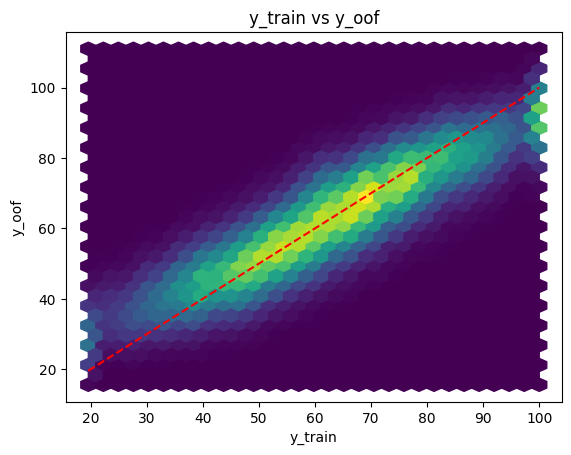

In [162]:
plt.hexbin(x=y_train, y=y_oof, gridsize=30)

plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    linestyle="--",
    color="red"
)

plt.xlabel("y_train")
plt.ylabel("y_oof")
plt.title("y_train vs y_oof")
plt.show()

In [163]:
coef = np.polyfit(y_train, y_oof, 1)
coef

array([ 0.77880868, 13.82598886])

In [164]:
np.corrcoef(y_train, y_oof)[0,1]

np.float64(0.8825569918268131)

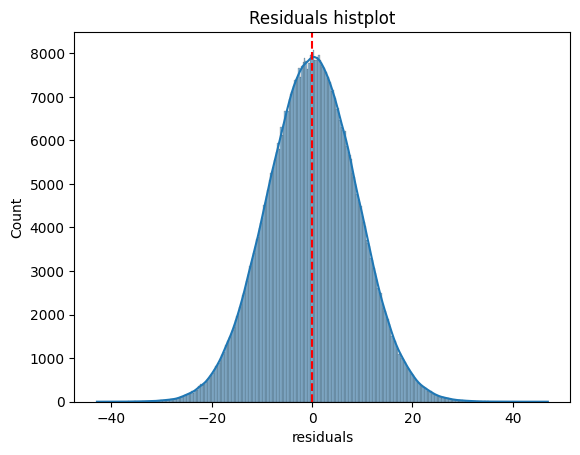

In [168]:
sns.histplot(residuals, kde=True)

plt.axvline(residuals.mean(), color='r', linestyle='--', label=f'Mean: {residuals.mean():.2f}')

plt.xlabel("residuals") 
plt.title("Residuals histplot")
plt.show()

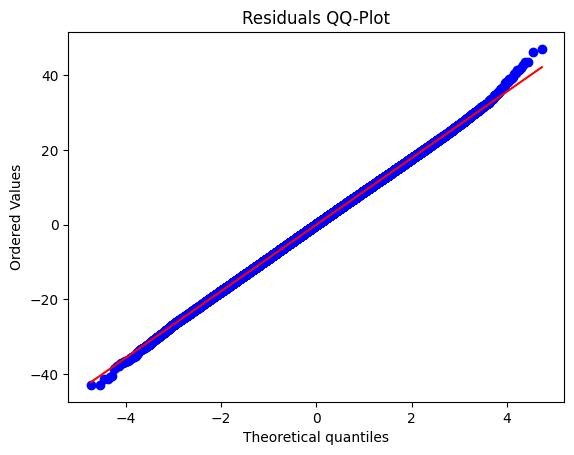

In [169]:
probplot(residuals, dist="norm", plot=plt)

plt.title("Residuals QQ-Plot")
plt.show()

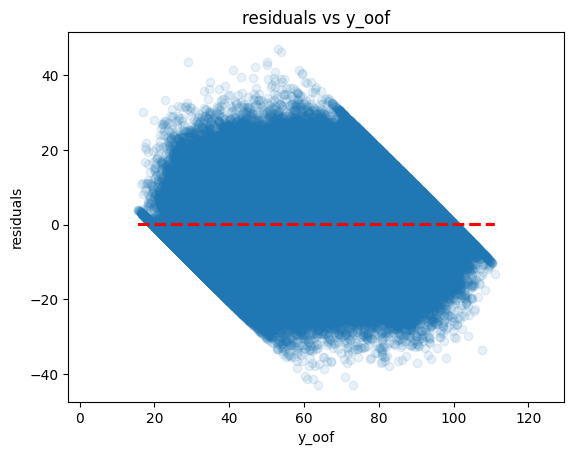

In [166]:
sns.regplot(x=y_oof, y=residuals, scatter_kws={'alpha':0.1}, line_kws=dict(linestyle="--", color="r"))

plt.axis('equal')
plt.xlabel("y_oof")
plt.ylabel("residuals")
plt.title("residuals vs y_oof")
plt.show()

In [167]:
np.polyfit(y_oof, residuals, 1)

array([ 0.00012605, -0.00793414])

In [174]:
df = pd.DataFrame({"y_train": y_train, "y_oof": y_oof})
df["bin"] = pd.qcut(df["y_train"], 10)

df["residual"] = df["y_train"] - df["y_oof"]

df.groupby("bin")["residual"].agg(["mean", "std"])

,mean,std
bin,,
"(19.598, 37.4]",-8.481889,7.083360
"(37.4, 45.5]",-4.021949,7.540529
"(45.5, 51.8]",-1.510474,7.869916
"(51.8, 57.4]",-0.847050,8.078403
"(57.4, 62.6]",-0.718536,8.695801
"(62.6, 67.9]",0.393580,8.345690
"(67.9, 73.4]",1.038461,8.135674
"(73.4, 79.4]",2.285170,7.774345
"(79.4, 88.0]",4.095257,7.630568


Métricas
    - RMSE: 8.894
    - MAE: 7.101
    - R2: 0.778
    - Residual mean: -5.607
Os resultados de RMSE, MAE e R2 são esperados pois, apesar de utilizar o y_oof, o y real usado ainda foi o y_train, que foi usado no fit. Ou seja, era esperado que as métricas fossem semelhante ao cross validate feito anteriormente. Já a média do resíduo mostra que há um pequeno viés sistemático (observational/measurement error).

Comparação entre y_oof e y_train: Em um cenário ideal, o y_oof e y_train tem uma relação linear com slope = 1 e intercept = 0 (y_oof = y_train). O hexplot demonstra que há uma relação linear que se aproxima um pouco ao ideal pois há uma concentração maior perto da reta, mas não está inteiramente sobre ela. Além disso, no extremo inferior há uma concetração acima da reta, e no extremo superior há uma concentração abaixo da reta. Apesar dessa diferença com a reta ideal, claramente não há uma não linearidade. O cálculo do slope (0.778) e do intercept (13.81) mostram que há problemas estruturais no modelo, tanto de escala (slope != 1) e viés global (intercept != 0). Conisderando que não é um problema de complexidade (modelos não lineares tiveram a mesma performance), não é regularização excessiva / underfit (regressão linear não teve um desempenho melhor e foi realizado um grid search), a principal hipótese de um slope e intercept fora do ideal é features não contêm informações suficientes para um melhor desempenho.

Resíduos: A curva do histograma dos resíduos se aproxima bastante de uma bell shaped curve. Esse comportamento é positivo pois há um único pico, significando que não há multimodalidade; e também é aparentemente simétrico, indicando que não há uma tendência de erro para algum caso extremo. Porém, o QQ-plot, que compara os quantils de uma curva normal com a distribuição em questão, no caso os resíduos, mostra que há desvios em ambas extremidades. Na extremidade inferior, o quantil dos resíduos é menor que o quantil da distribuição normal, enquanto na extremidade superior, o quantil dos resíduos pe maior que o quantil da distribuição normal.

Resíduos e y_oof: o regplot mostra claramente que há uma tendência monotônica decrescente entre y_pred e os resíduos. Apesar do slope global do erro ser praticamente zero (0.0001), um cálculo de resíduos por bins mostra essa tendência em questão. Essa análise reitera e comprova o comportamento das extremidades do hexplot entre y_oof e y_train: o modelo prediz valores maiores que o esperado para valores baixos, e prediz valores menores que o esperado para valores maiores. Pelo menos, a binarização demonstrou que não há heterocedasticidade (diferente variâncias entre bins).

Com indicios de problema de calibração / escala, demonstrado pelo y_oof vs y_train e principalmente resíduos vs y_oof, será feito uma última ação sobre o modelo: tentar uma calibração linear. Baseado no slope e intercept da relação linear entre y_pred e y, aplicar uma transformação no próprio y_pred. Não há mudanças no preprocessamento nem no treino do modelo, apenas no output do modelo.

In [ ]:
class OOFLinearCalibration(BaseEstimator, RegressorMixin):
    
    def __init__(self, base_model, n_splits=5, random_state=42):
        self.base_model = base_model
        self.n_splits = n_splits
        self.random_state = random_state
        self.calibrator = LinearRegression()
        
    def fit(self, X, y):
        kf = KFold(
            n_splits=self.n_splits,
            shuffle=True,
            random_state=self.random_state
        )
        
        oof_preds = np.zeros(len(y))
        
        for train_idx, val_idx in kf.split(X):
            model = clone(self.base_model)
            
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            
            model.fit(X_train, y_train)
            oof_preds[val_idx] = model.predict(X_val)
        
        self.calibrator.fit(
            oof_preds.reshape(-1, 1),
            y
        )
        
        # treinar modelo final em todos os dados
        self.model_ = clone(self.base_model)
        self.model_.fit(X, y)
        
        return self
    
    def predict(self, X):
        y_pred = self.model_.predict(X)
        return self.calibrator.predict(y_pred.reshape(-1, 1))

ridge_preprocess_final_ = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

ridge_pipeline_final_ = Pipeline([
        # ('feature_engineering', feature_engineering),
        ("column_dropper", columnDropperTransformer('age')),
        ('preprocess', ridge_preprocess_final_),
        ('model', Ridge(alpha=0.001, solver='lbfgs', positive=True, tol=1e-05, random_state=42))
    ]
)

pipeline = Pipeline([
    ("model", OOFLinearCalibration(ridge_pipeline_final_))
])

pipeline.fit(X_train, y_train)
y_oof_cal = pipeline.predict(X_train)

print("RMSE: ", root_mean_squared_error(y_train, y_oof_cal))
print("MAE: ", mean_absolute_error(y_train, y_oof_cal))
print("R2: ", r2_score(y_train, y_oof_cal))

RMSE:  8.894475942520666
MAE:  7.100992806038988
R2:  0.7789236881446746


Os resultados foram praticamente iguais. Com isso e todos outros testes e resultados anteriores, há um forte indício de limite informacional.

# 6 Test

In [183]:
with open('./data/test.csv', 'r') as f:
    df_test = pd.read_csv(f)

X_test = df_test

In [184]:
ridge_preprocess_final = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "category", "str"]))
], remainder='passthrough')

ridge_pipeline_final = Pipeline([
        #('feature_engineering', feature_engineering),
        ("column_dropper", columnDropperTransformer('age')),
        ('preprocess', ridge_preprocess_final),
        ('model', Ridge(random_state=42))
    ]
)

best_model = ridge_pipeline_final.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_pred

array([71.82706051, 69.44401697, 87.4808604 , ..., 90.01369563,
       55.51428108, 68.43159878], shape=(270000,))